Import libraries, install packages, set dataset path and load data

In [ ]:
#!pip install transformers
!pip install -q git+https://github.com/huggingface/transformers.git datasets
!pip install datasets[vision]
!pip install transformers datasets evaluate
!pip install --upgrade accelerate

# from PIL import ImageFile
# ImageFile.LOAD_TRUNCATED_IMAGES = True

from datasets import load_dataset

tomato_train='/train_set_path/'
tomato_val='/validation_set_path/'
tomato_test='/test_set_path/'

db_dir=tomato_train
db_dir2=tomato_val
db_dir3=tomato_test
dataset = load_dataset("imagefolder", data_dir=db_dir, save_infos=False, verification_mode='no_checks')
dataset2 = load_dataset("imagefolder", data_dir=db_dir2, save_infos=False, verification_mode='no_checks')
dataset3 = load_dataset("imagefolder", data_dir=db_dir3, save_infos=False, verification_mode='no_checks')
dataset["train"][0]["image"]
model_namez="tomato_diseseas_detection"

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Set model checkpoint and batch size

In [ ]:
model_checkpoint = "google/vit-base-patch16-224"

batch_size = 64 # batch size for training and evaluation

Huggingface login (HF access token required)

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

Check if dataset features and labels are imported correctly

In [ ]:
dataset["train"].features

In [ ]:
dataset["train"].features["label"]

Create label dicts

In [ ]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

labels2 = dataset2["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels2):
    label2id[label] = i
    id2label[i] = label  

labels3 = dataset3["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels3):
    label2id[label] = i
    id2label[i] = label

id2label[0]

Import the model's image processor

In [ ]:
from transformers import AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained(model_checkpoint)
image_processor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

Set transforms to be executed on dataset splits

In [ ]:
from torchvision.transforms import RandomResizedCrop, Resize, Compose, CenterCrop, Normalize, ToTensor, RandomHorizontalFlip, RandAugment, AutoAugment, TrivialAugmentWide, AugMix
normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)

train_transforms = Compose([Resize(size), CenterCrop(size), RandAugment(), ToTensor(), normalize]) 
val_transforms = Compose([Resize(size), CenterCrop(size), ToTensor(), normalize])

def preprocess_train(examples):
    examples["pixel_values"] = [train_transforms(img.convert("RGB")) for img in examples["image"]] 
    del examples["image"]
    return examples

def preprocess_val(examples):
    examples["pixel_values"] = [val_transforms(img.convert("RGB")) for img in examples["image"]] 
    del examples["image"]
    return examples

Apply transforms

In [ ]:
train_ds = dataset['train']
val_ds = dataset2['train']
test_ds = dataset3['train']

from datasets import Image
train_ds_undec = train_ds.cast_column('image', Image(decode=False))

from datasets import Image
val_ds_undec = val_ds.cast_column('image', Image(decode=False))

from datasets import Image
test_ds_undec = test_ds.cast_column('image', Image(decode=False))

train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)
test_ds.set_transform(preprocess_val)

Check on first training set image

In [ ]:
train_ds[0]

{'label': 0,
 'pixel_values': tensor([[[-0.2314, -0.2627, -0.2863,  ..., -1.0000, -1.0000, -1.0000],
          [-0.2627, -0.2706, -0.2863,  ..., -1.0000, -1.0000, -1.0000],
          [-0.2706, -0.2941, -0.2863,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-0.3569, -0.3569, -0.3647,  ..., -1.0000, -1.0000, -1.0000],
          [-0.4745, -0.4824, -0.4824,  ..., -1.0000, -1.0000, -1.0000],
          [-0.7725, -0.7647, -0.7725,  ..., -1.0000, -1.0000, -1.0000]],
 
         [[-0.2314, -0.2627, -0.2863,  ..., -1.0000, -1.0000, -1.0000],
          [-0.2627, -0.2706, -0.2863,  ..., -1.0000, -1.0000, -1.0000],
          [-0.2706, -0.2941, -0.2863,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-0.3569, -0.3569, -0.3647,  ..., -1.0000, -1.0000, -1.0000],
          [-0.4745, -0.4824, -0.4824,  ..., -1.0000, -1.0000, -1.0000],
          [-0.7725, -0.7647, -0.7725,  ..., -1.0000, -1.0000, -1.0000]],
 
         [[-0.2314, -0.2627, -0.2863,  ..., -1.0000, -1.0000, -1.0000],

Load model and Trainer

In [ ]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained( 
    model_checkpoint,
    ignore_mismatched_sizes=True,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Define collate function

In [ ]:
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

Define metrics

In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, auc, roc_curve, RocCurveDisplay, ConfusionMatrixDisplay, recall_score, confusion_matrix 
import matplotlib.pyplot as plt

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.

class_names = labels

def compute_metrics(eval_pred):
  labels = eval_pred.label_ids
  predictions = np.argmax(eval_pred.predictions, axis=1)
  acc = accuracy_score(labels, predictions)
  plt.show()
  ConfusionMatrixDisplay.from_predictions(labels, predictions, cmap='viridis', colorbar=False, display_labels=class_names)
  plt.show()
  return {
      'accuracy': acc }
  return metrics.compute(predictions=predictions, references=eval_pred.label_ids)

Set Trainer args and hyperparams and start training

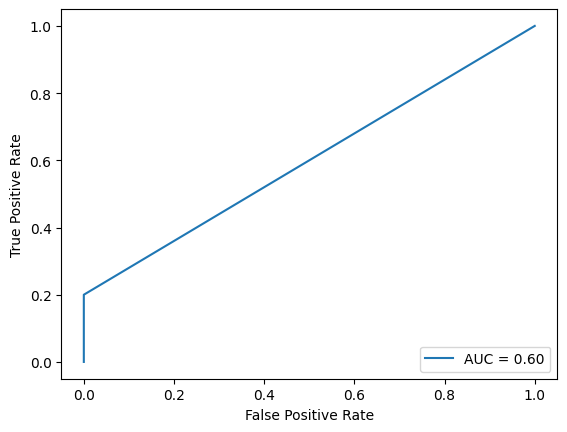

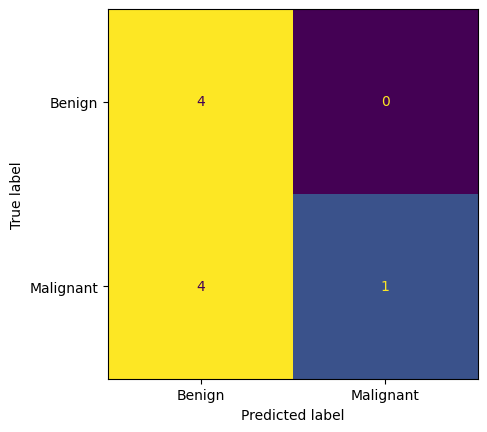

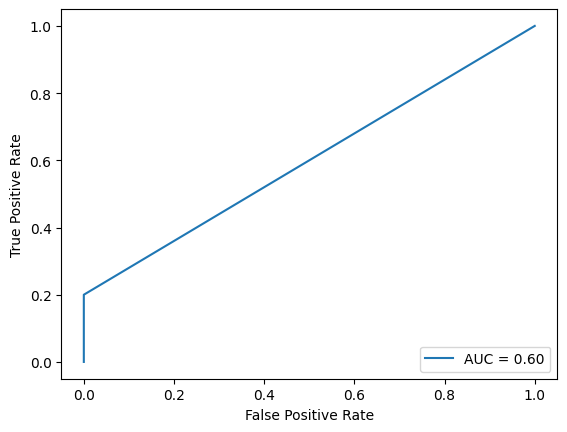

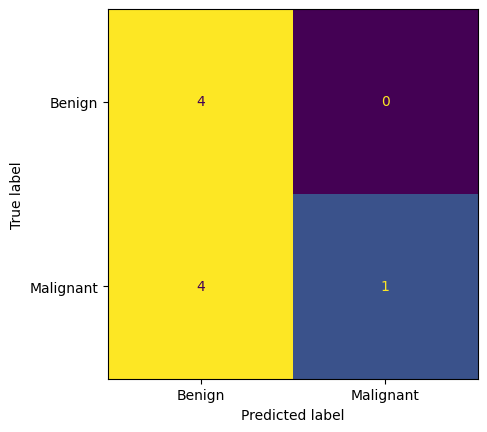

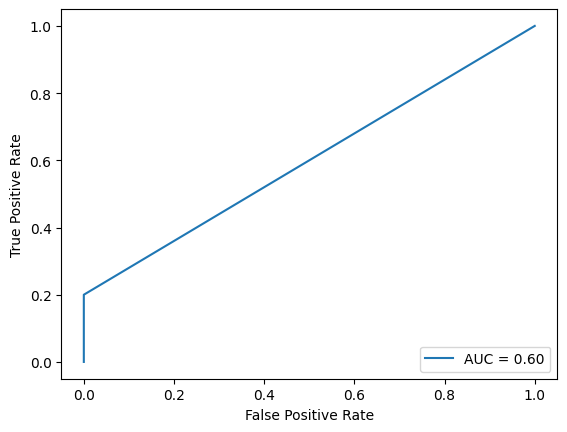

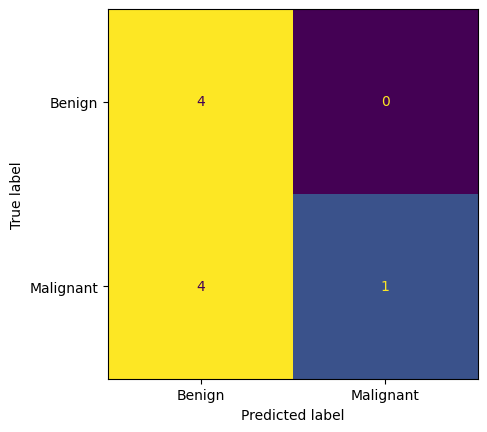

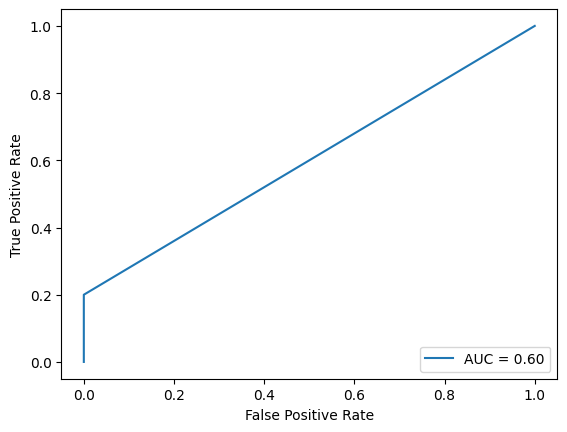

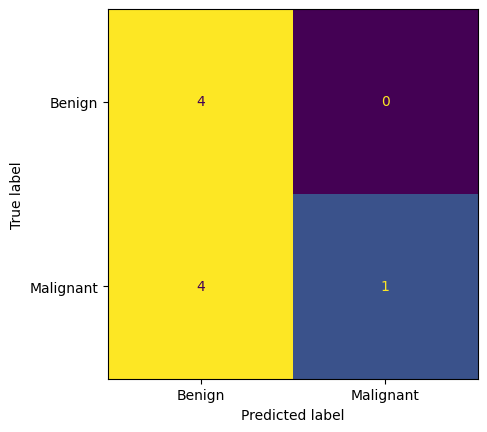

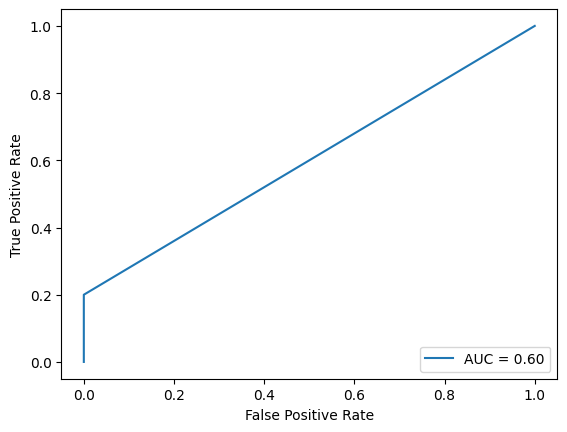

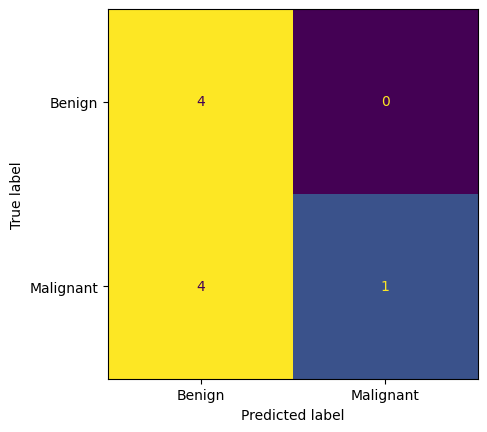

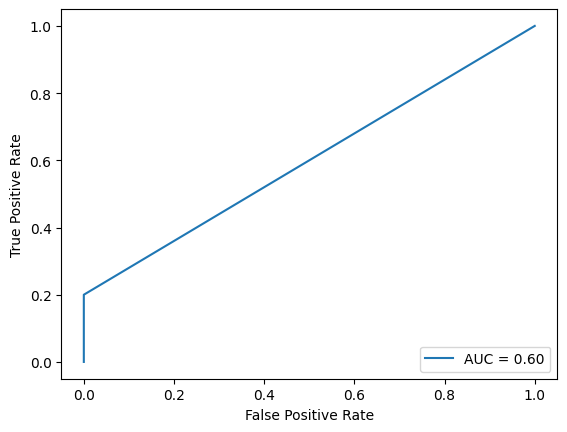

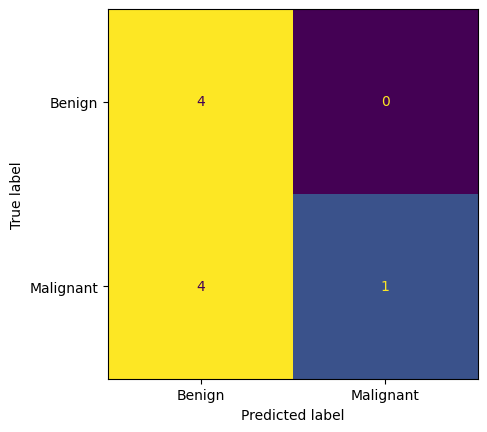

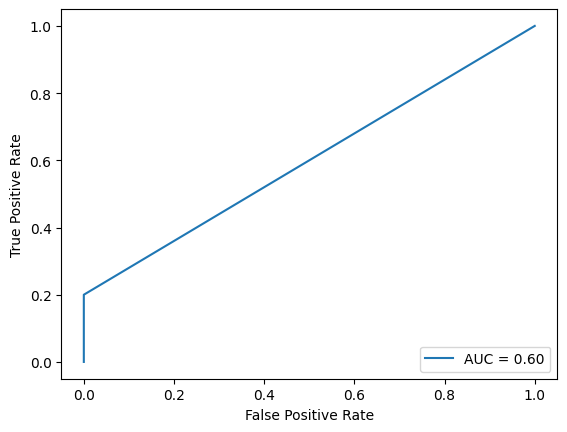

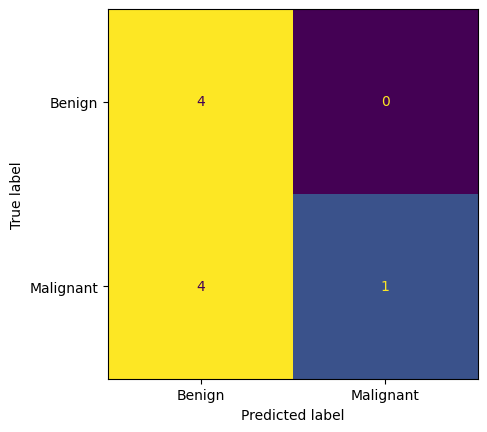

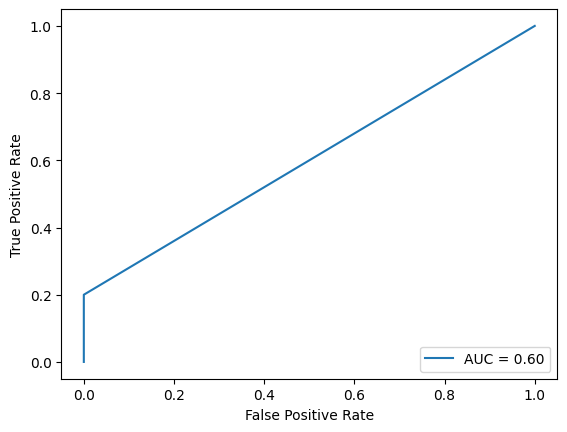

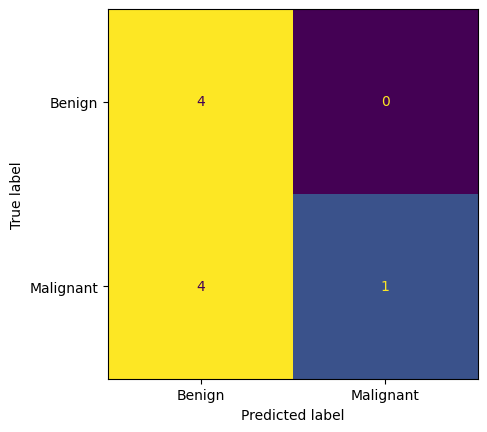

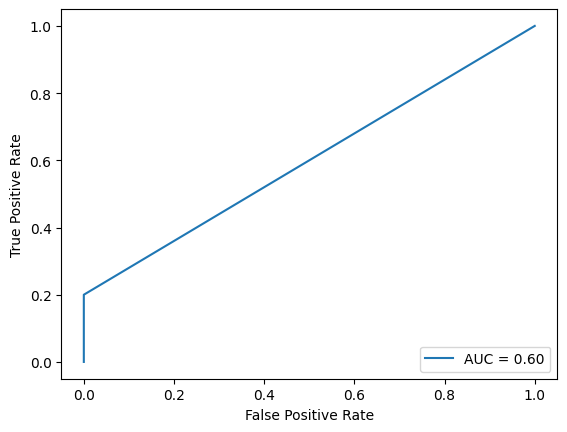

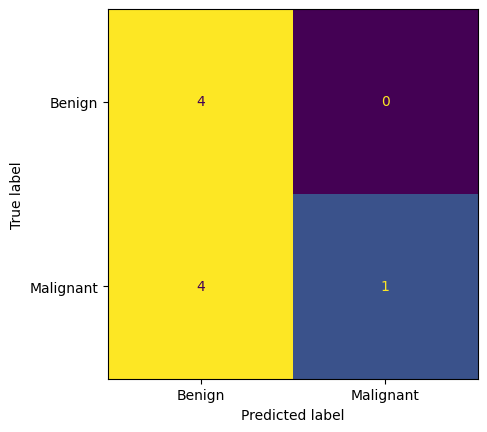

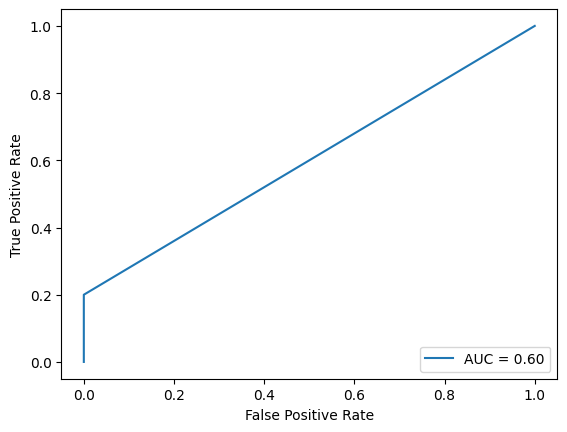

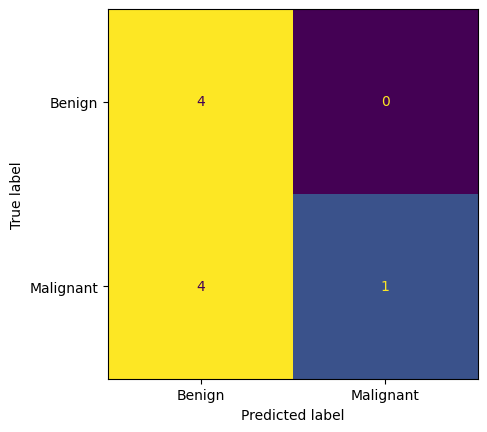

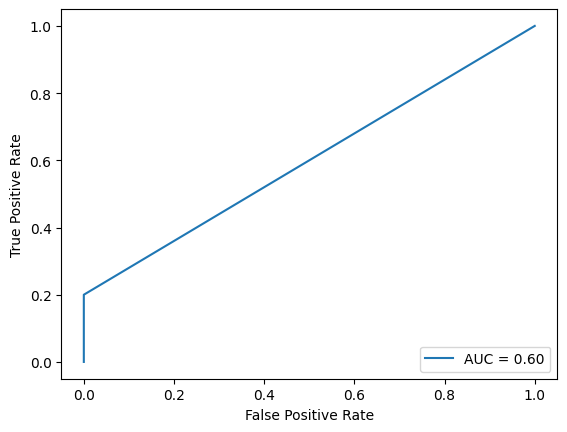

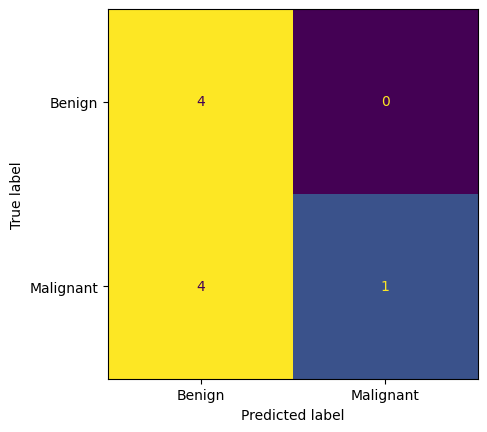

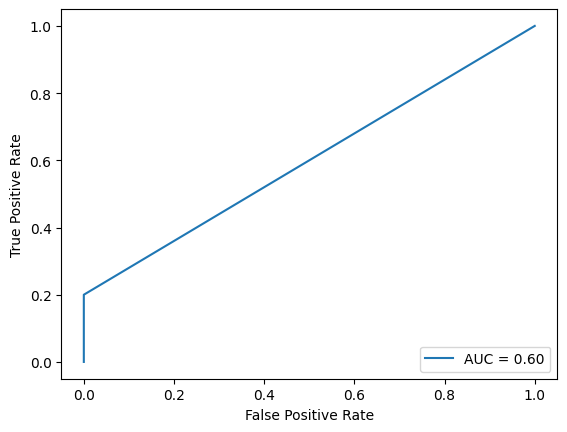

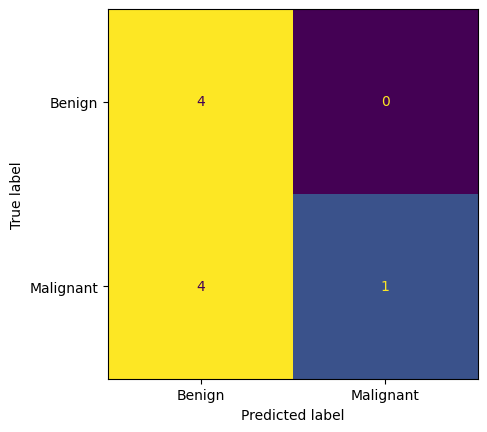

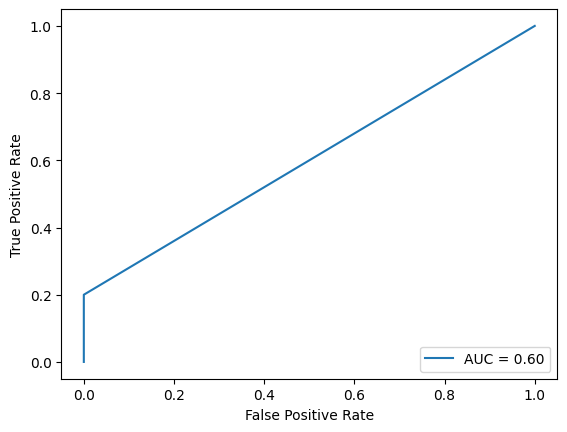

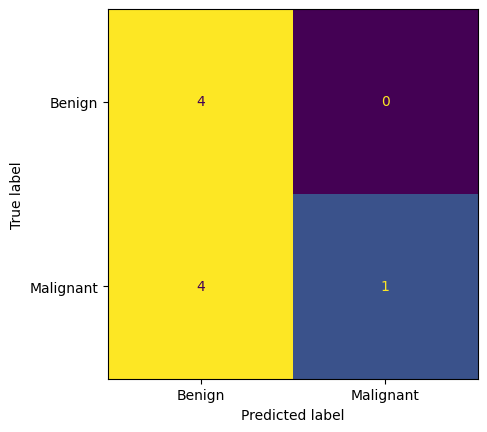

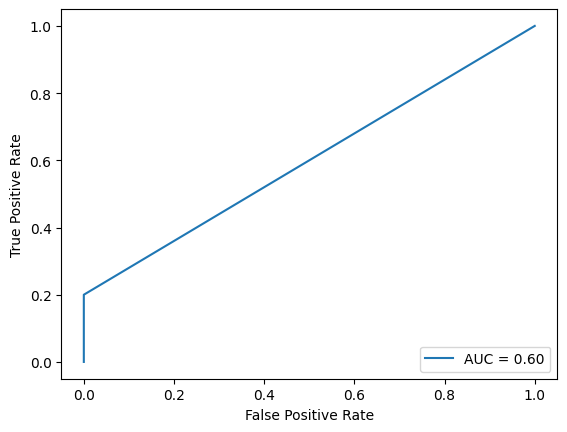

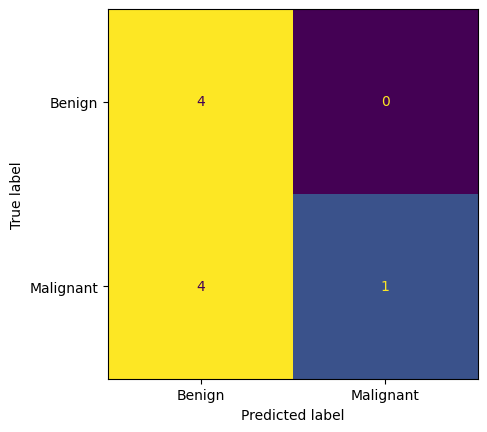

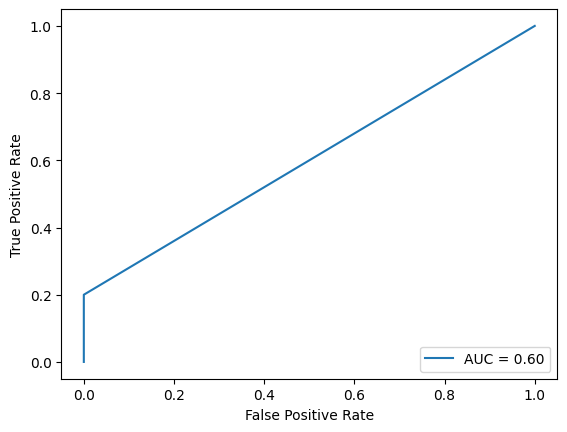

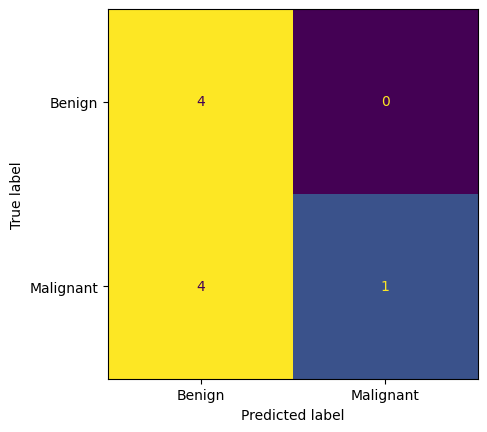

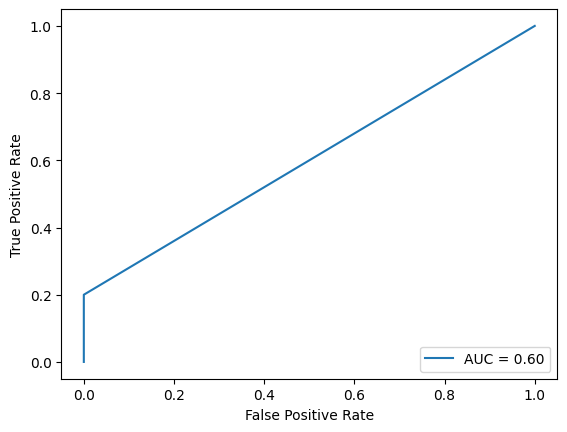

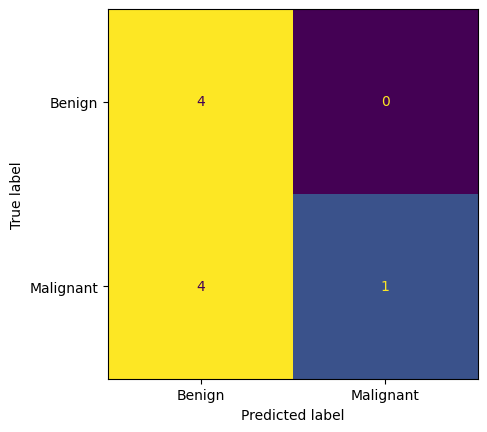

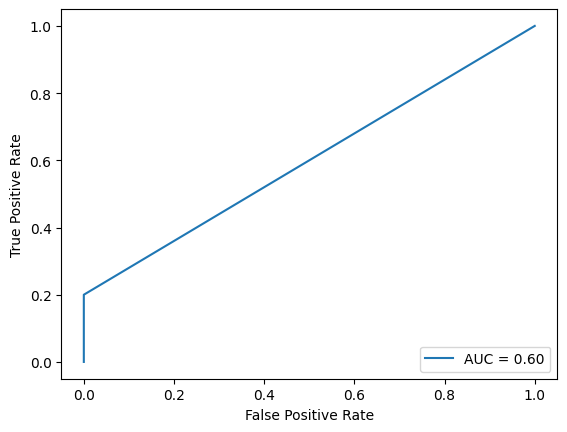

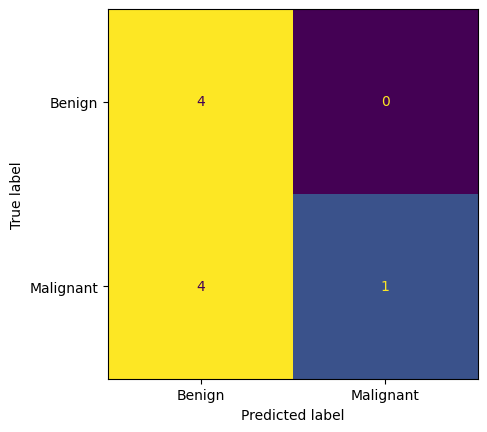

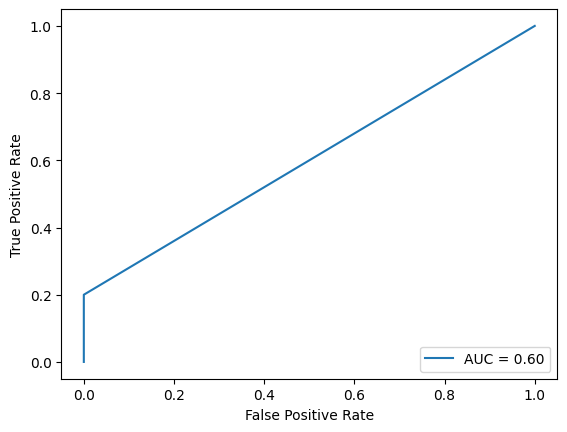

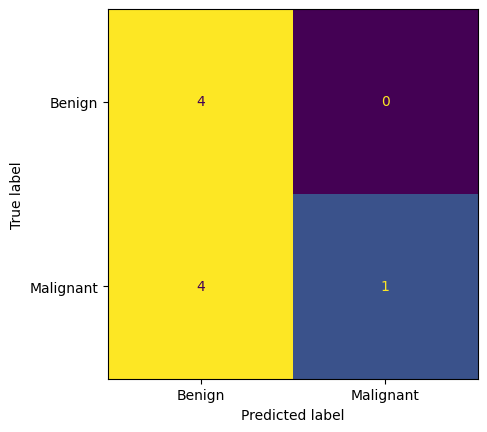

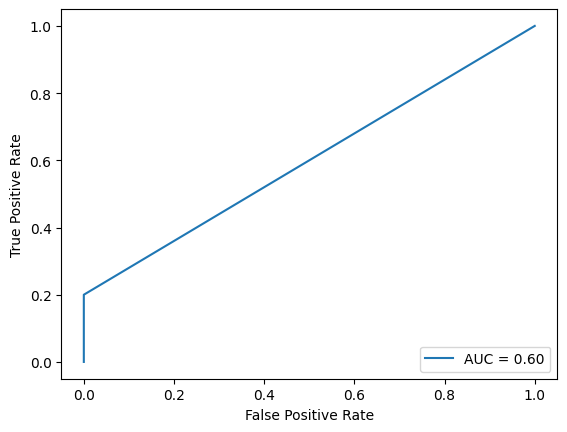

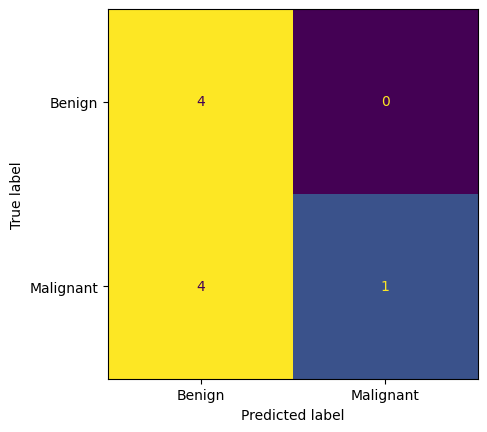

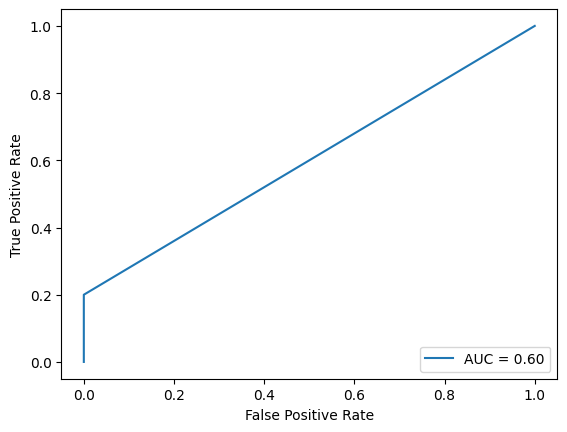

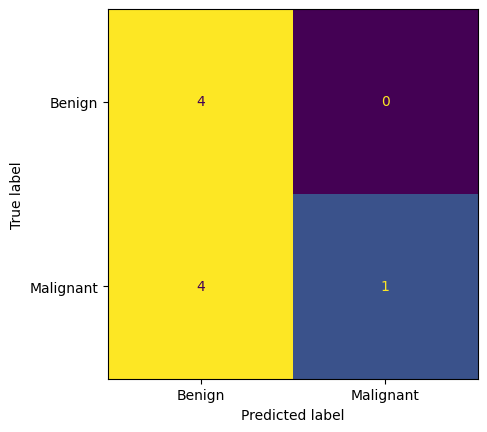

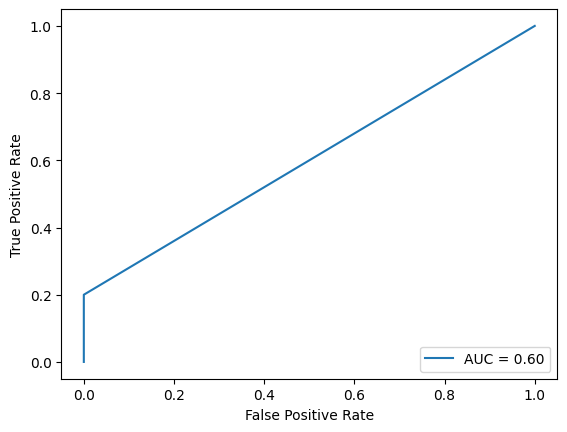

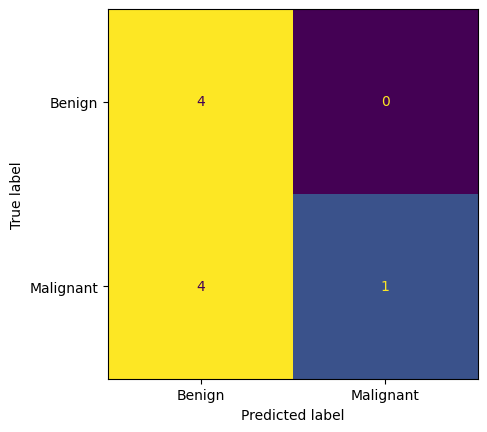

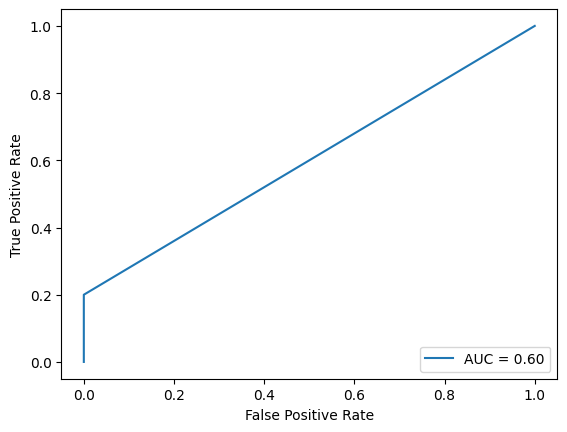

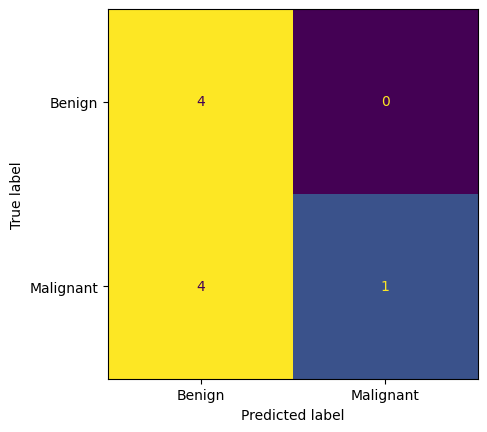

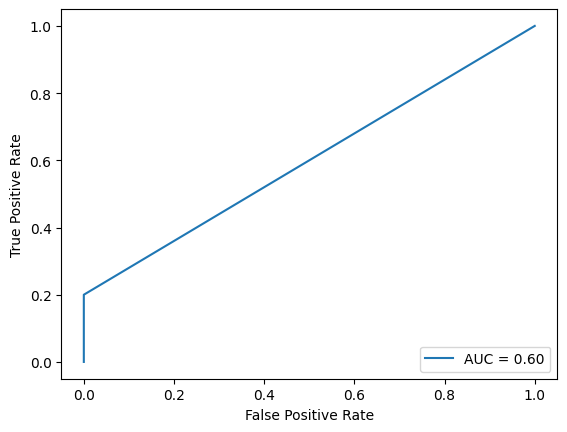

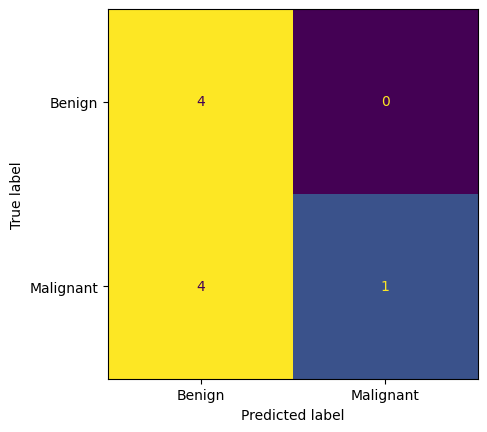

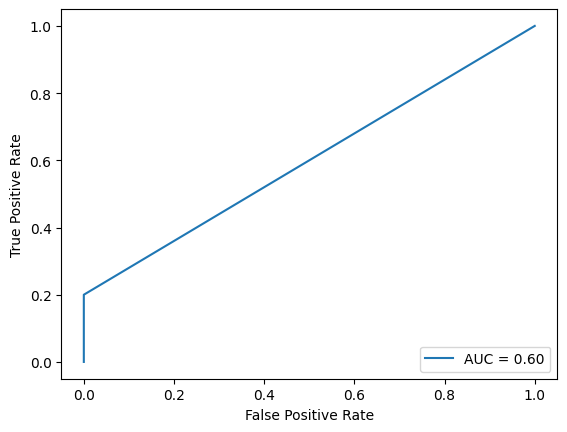

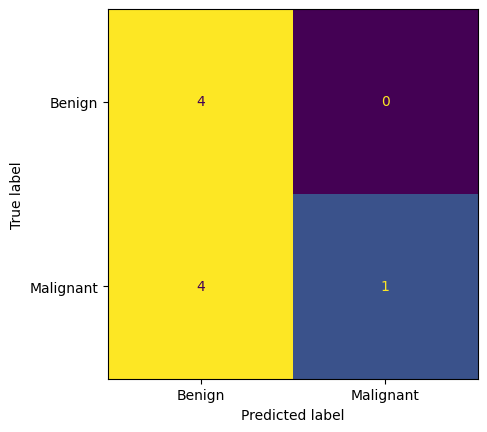

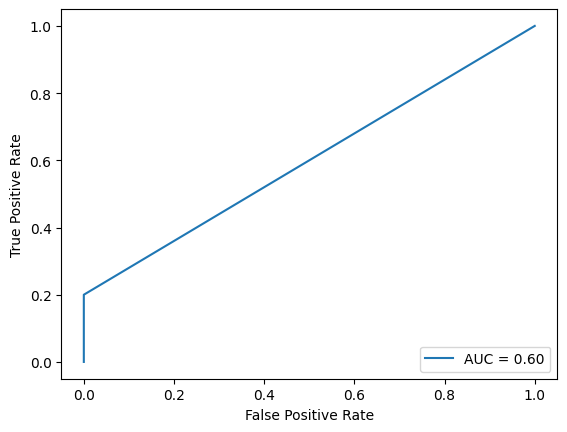

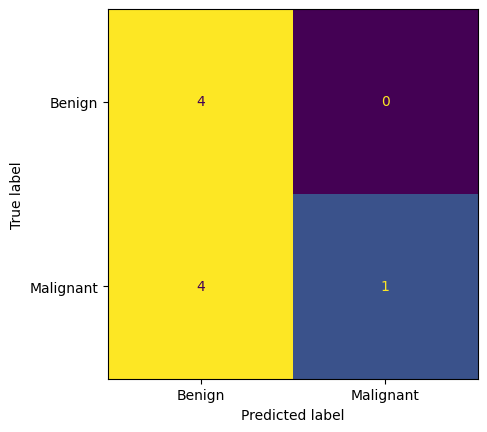

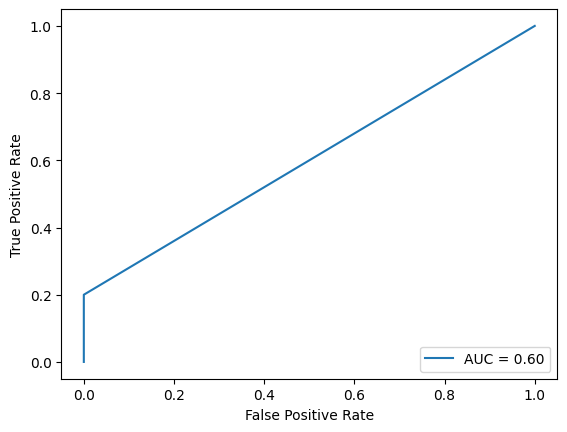

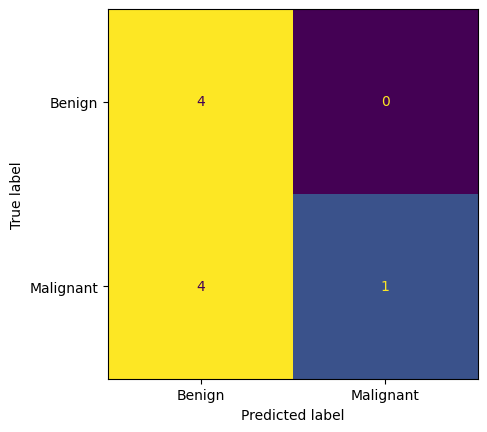

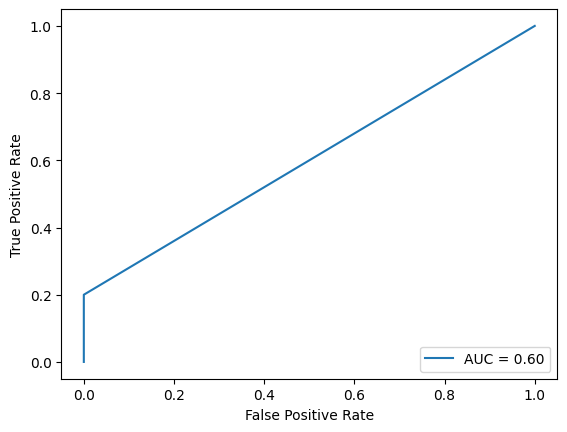

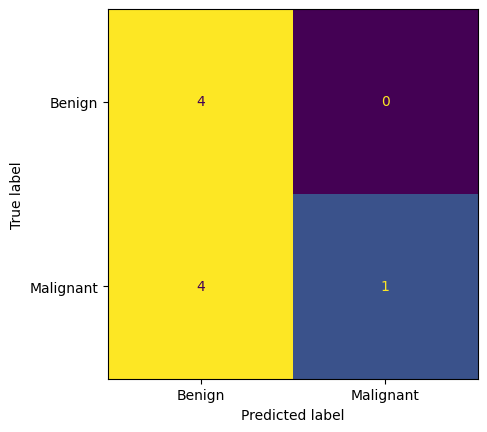

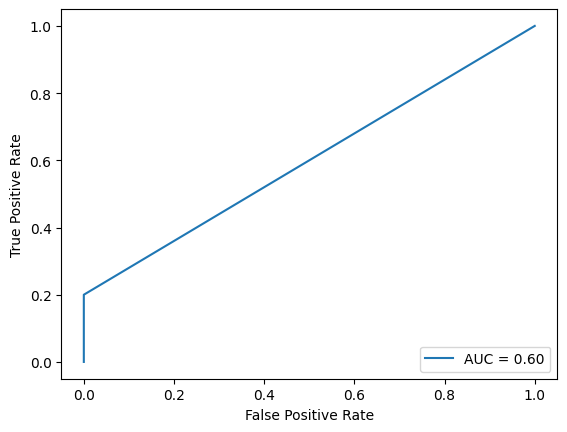

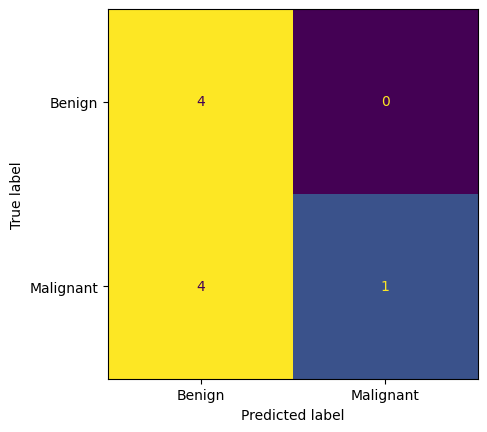

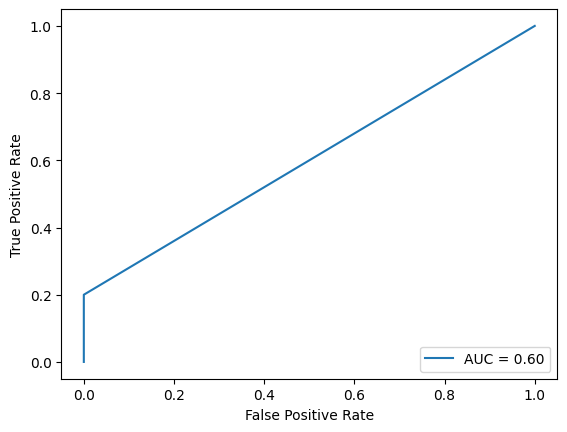

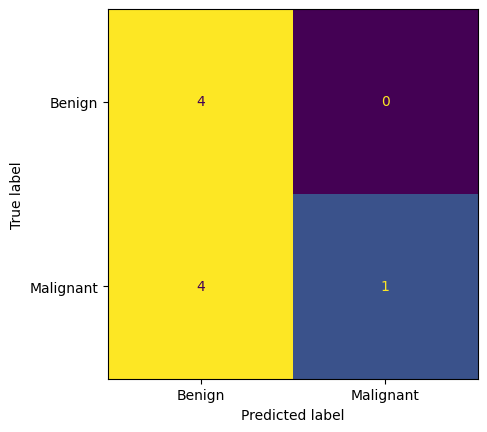

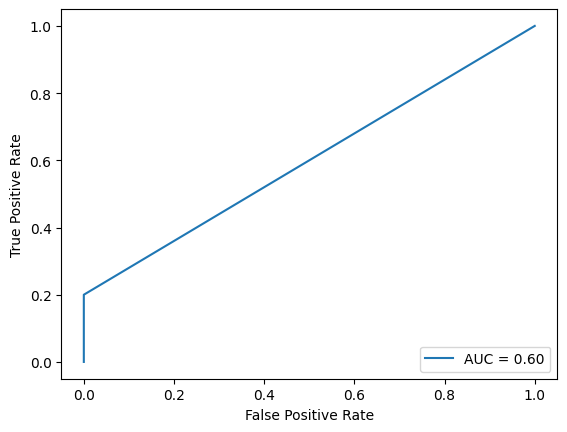

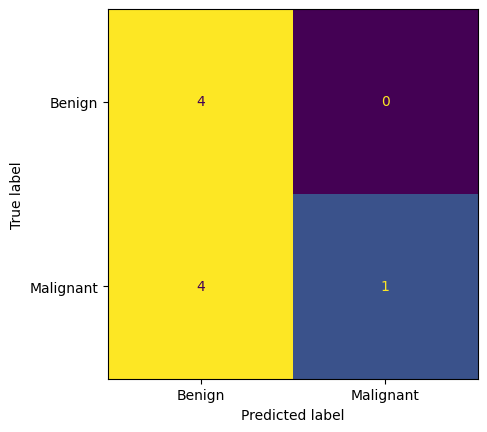

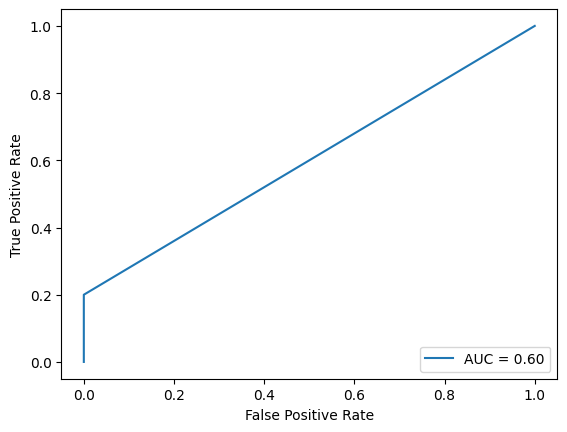

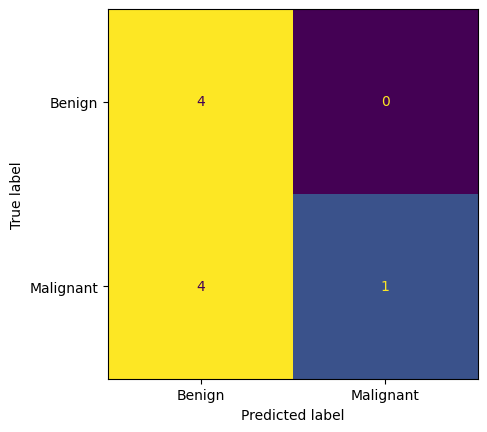

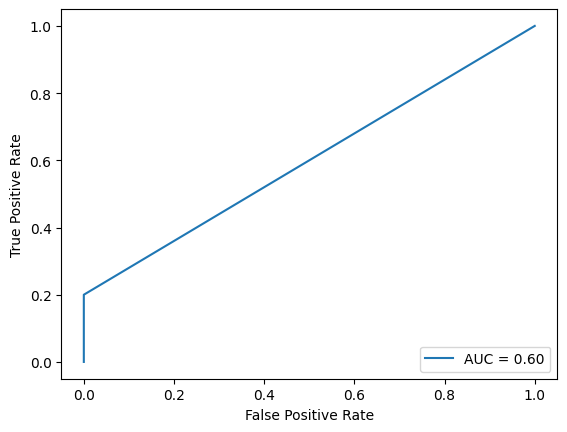

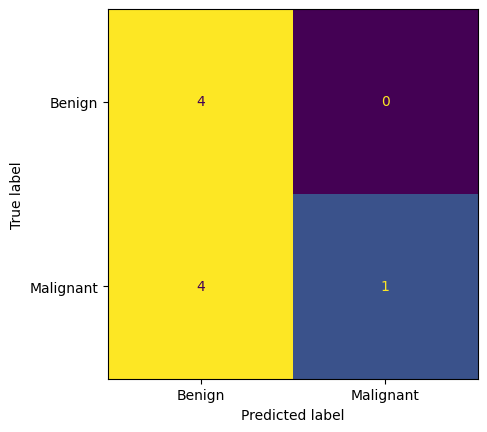

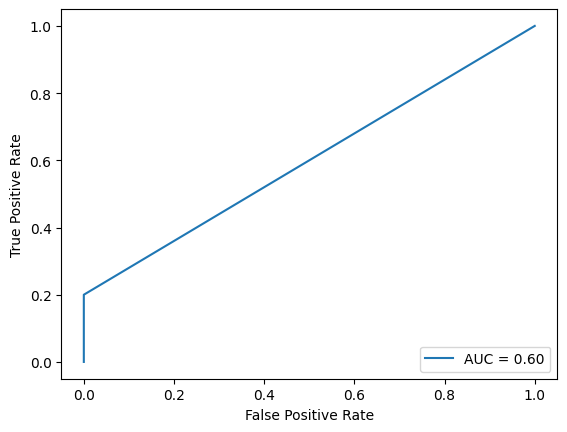

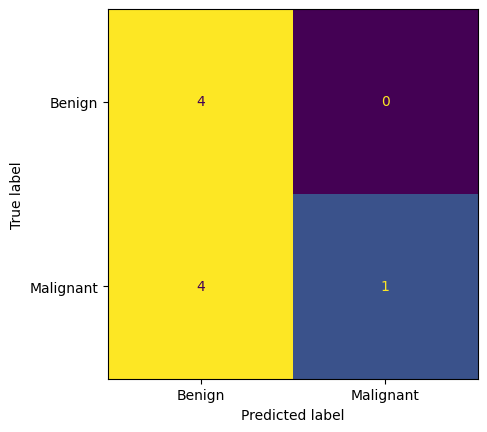

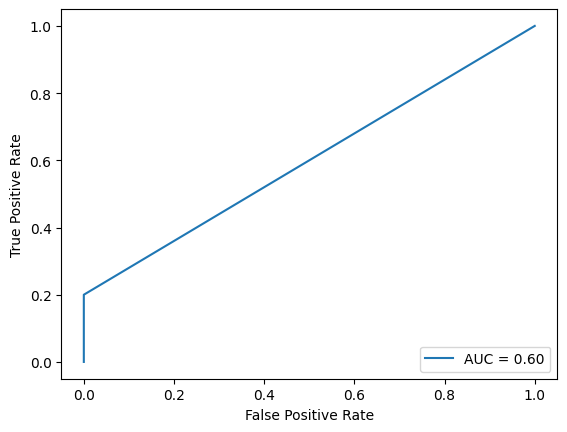

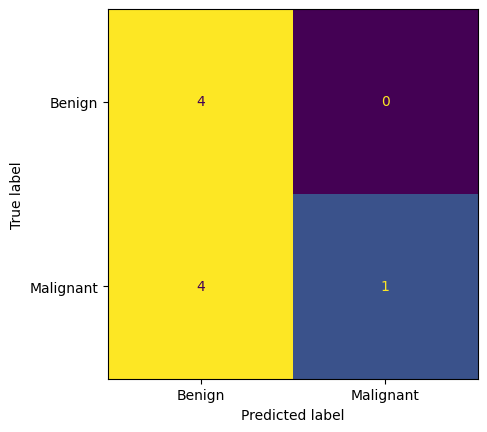

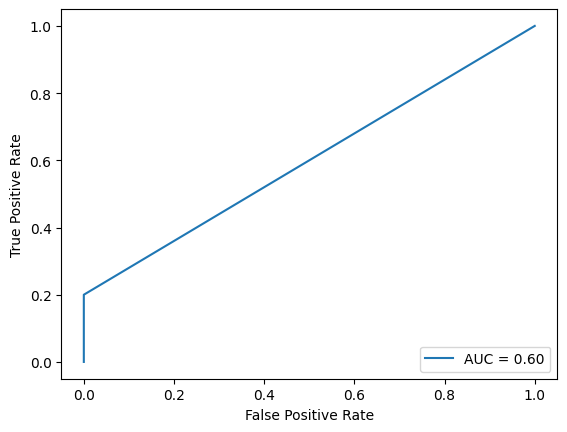

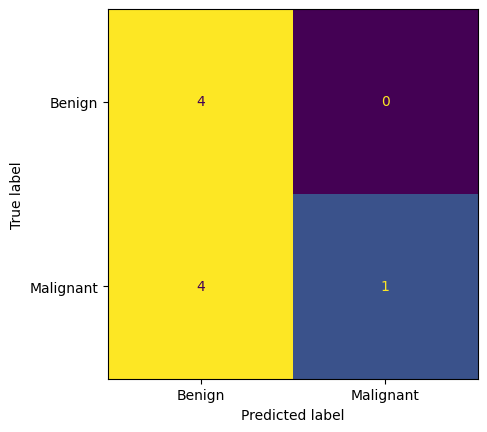

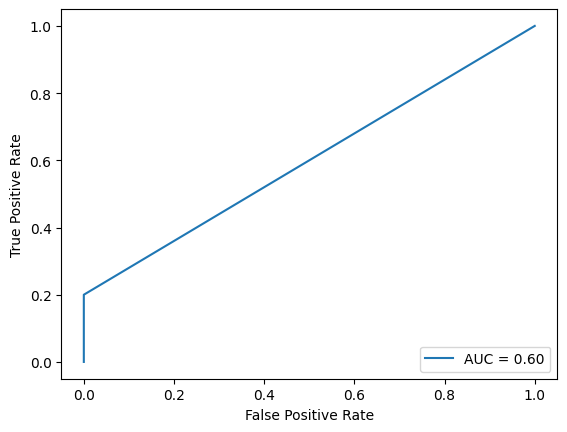

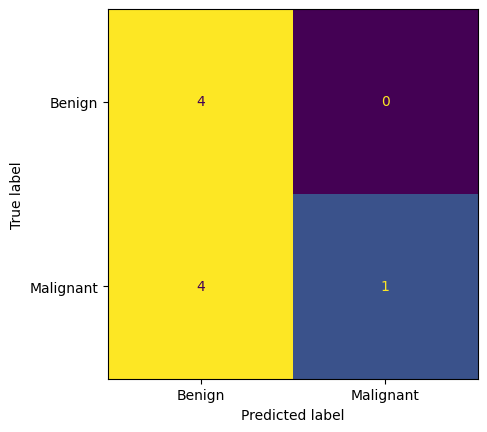

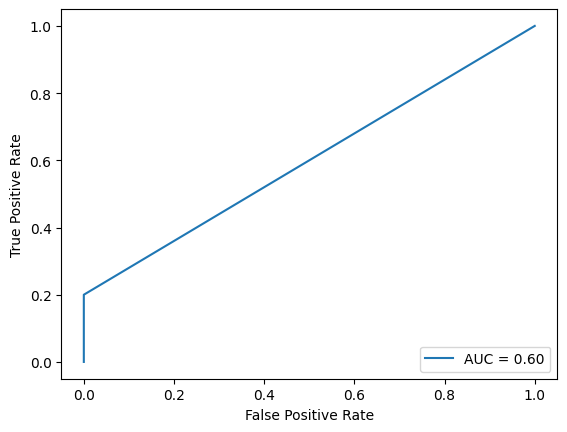

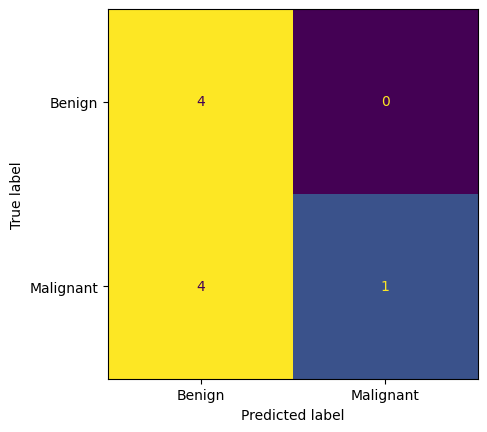

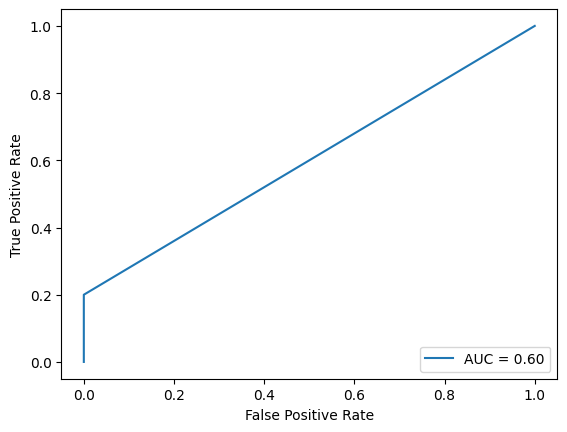

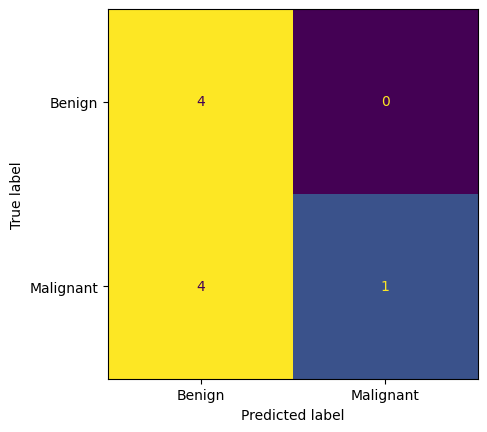

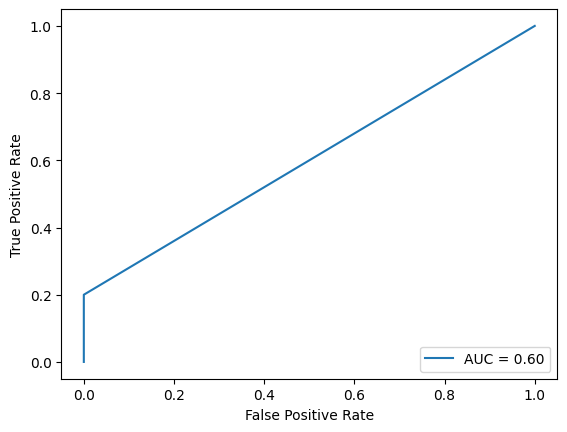

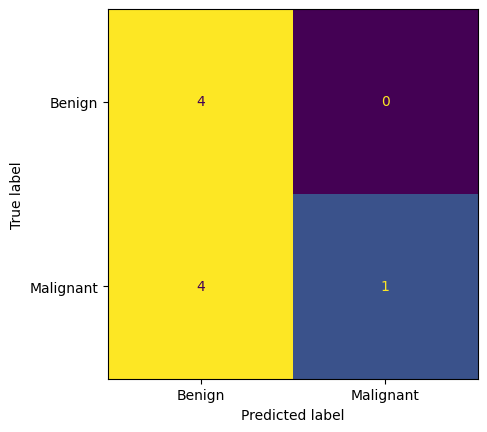

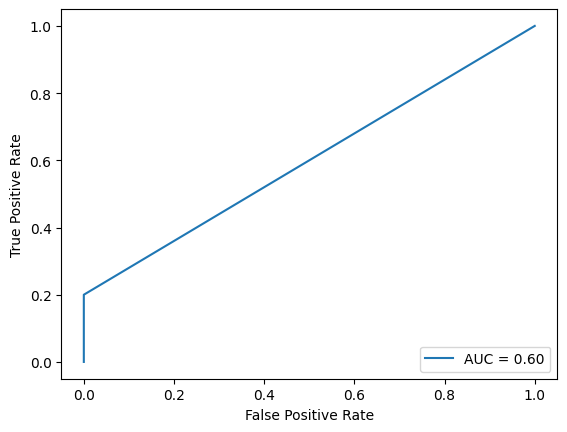

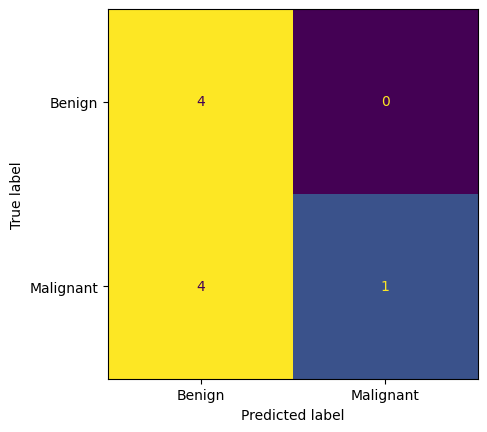

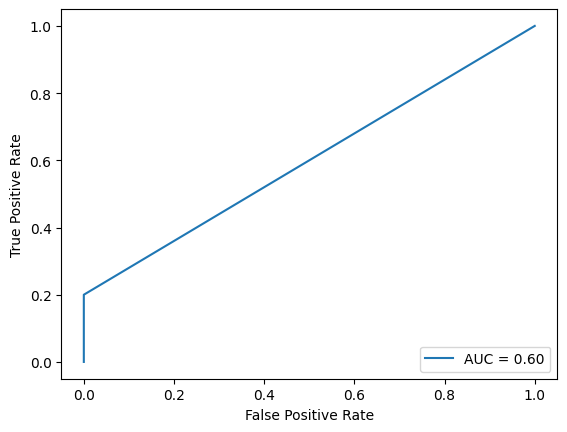

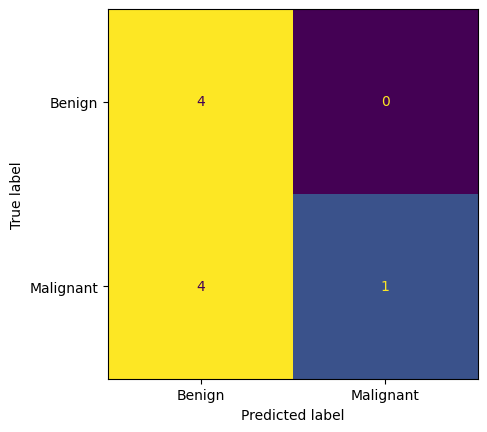

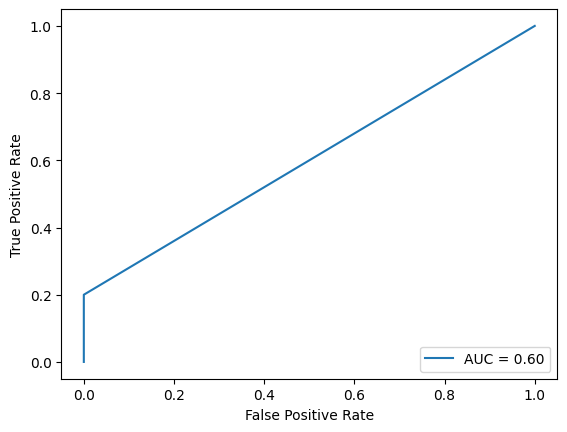

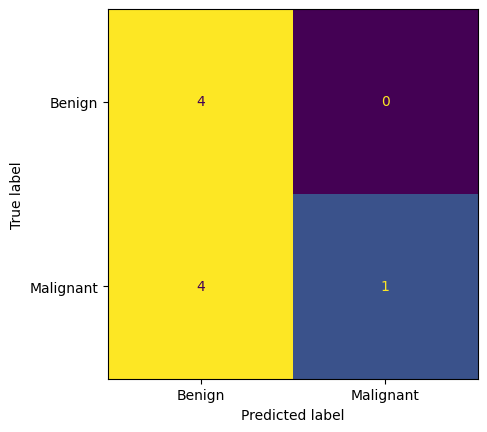

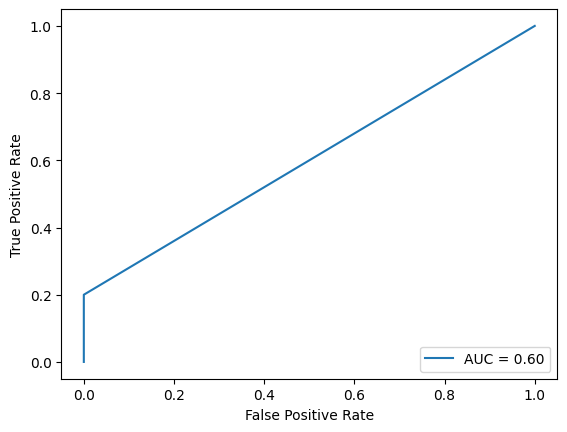

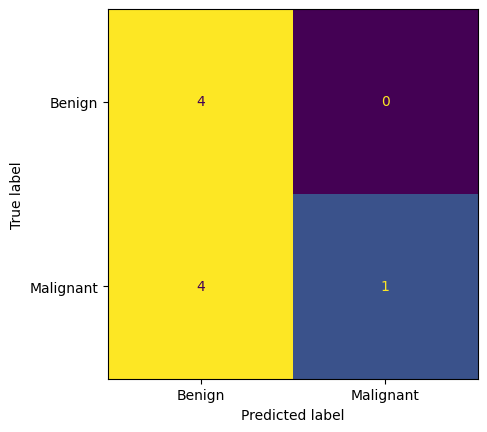

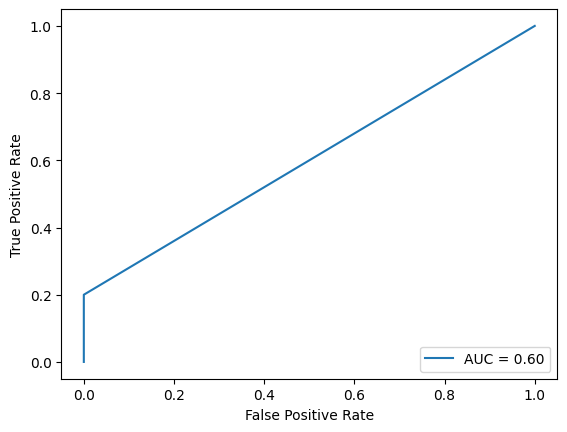

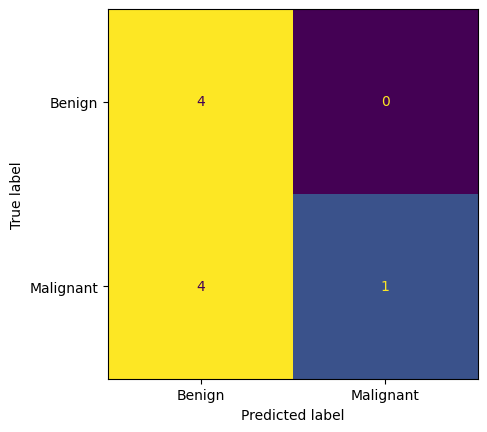

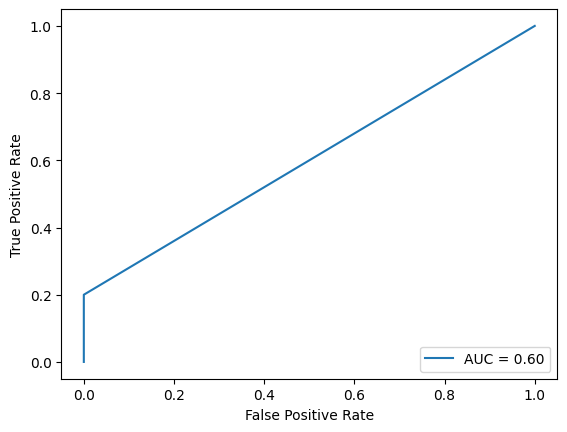

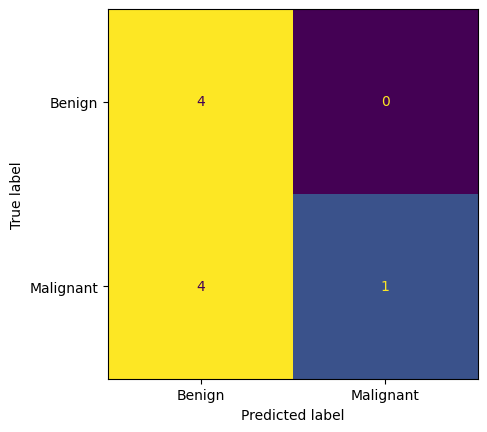

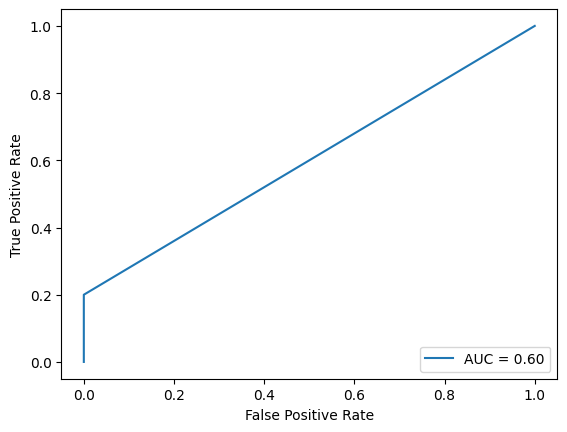

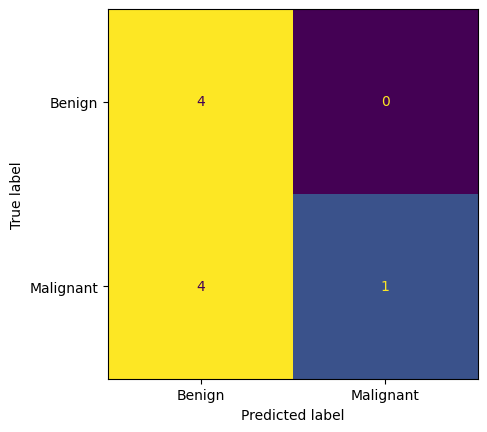

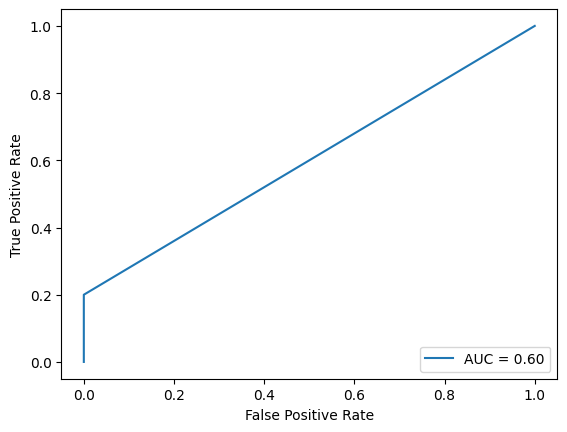

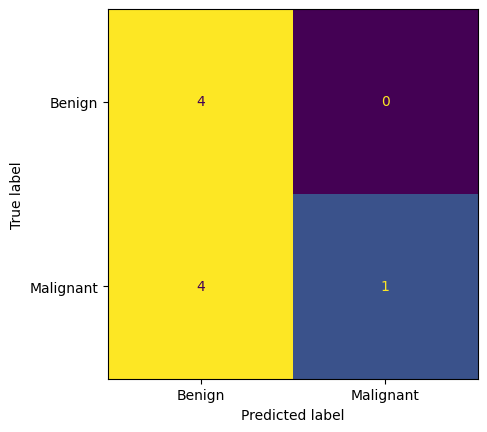

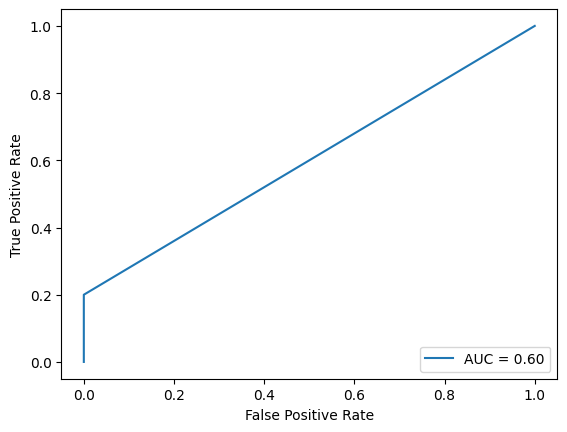

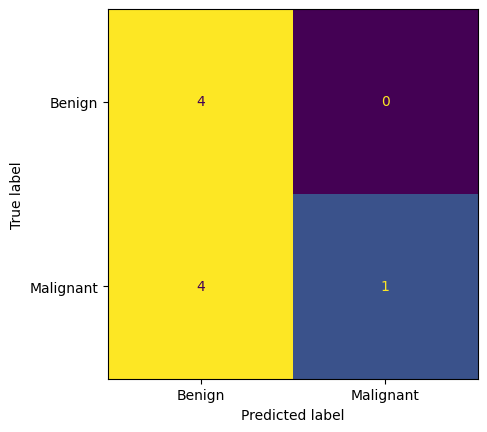

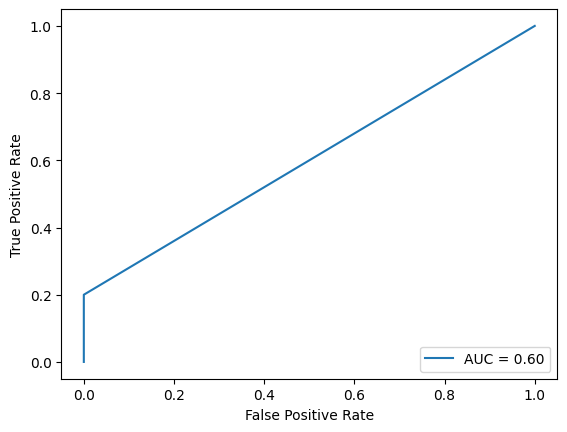

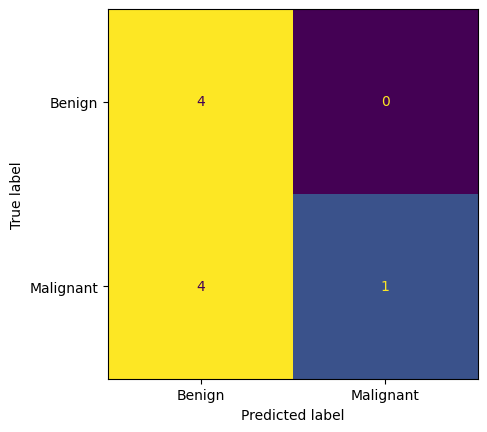

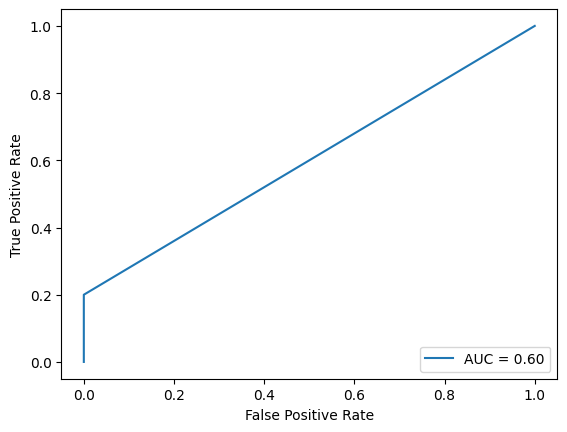

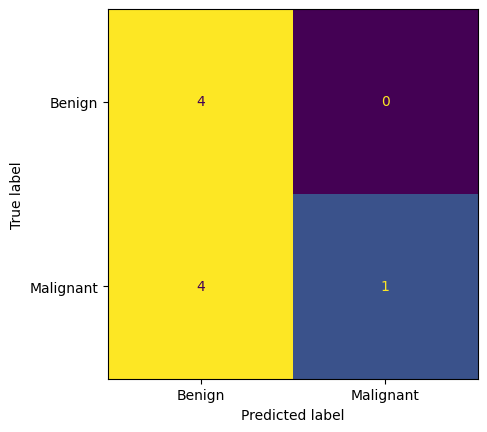

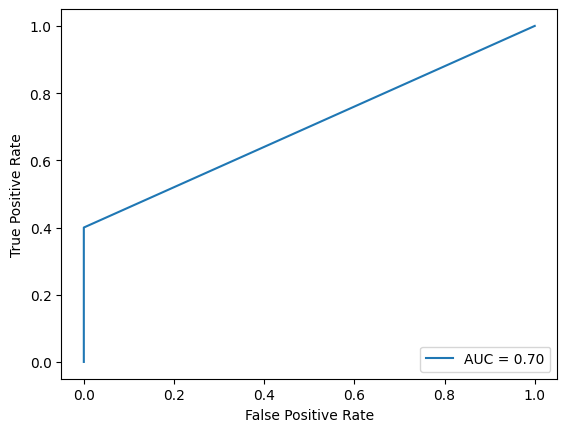

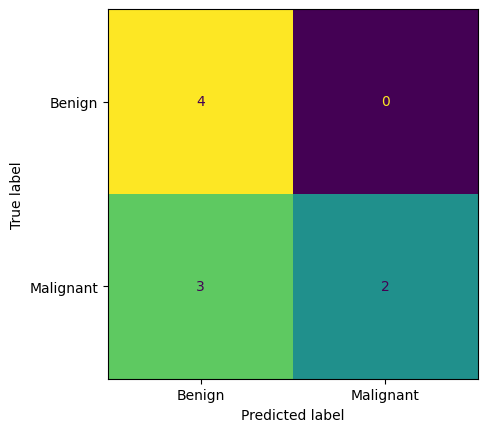

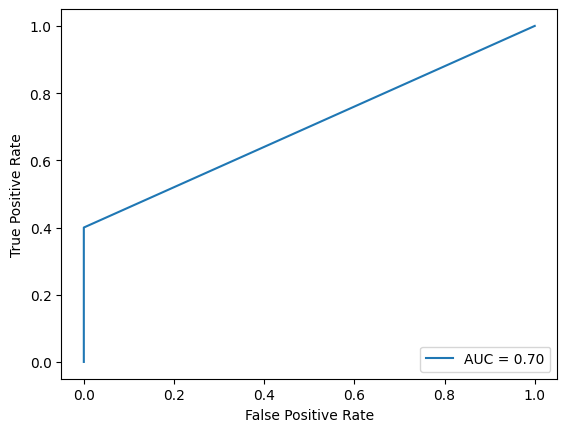

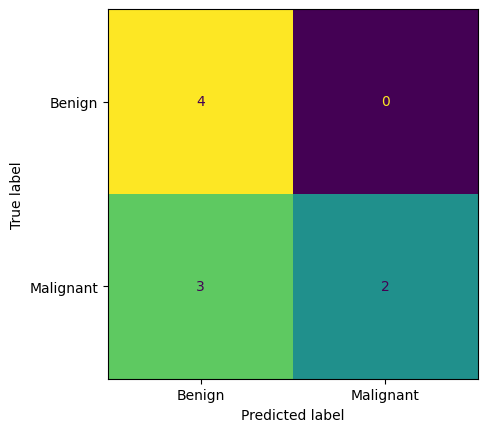

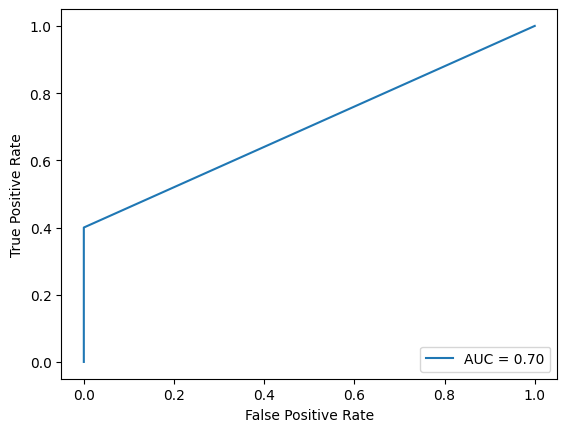

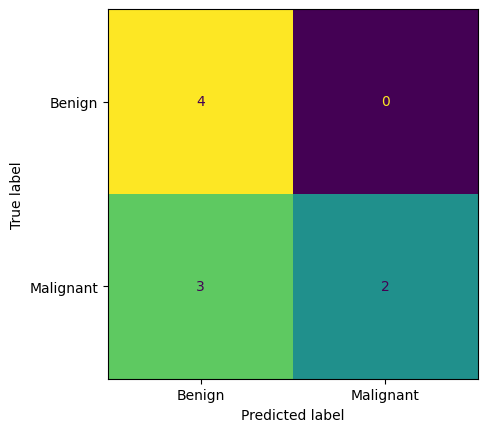

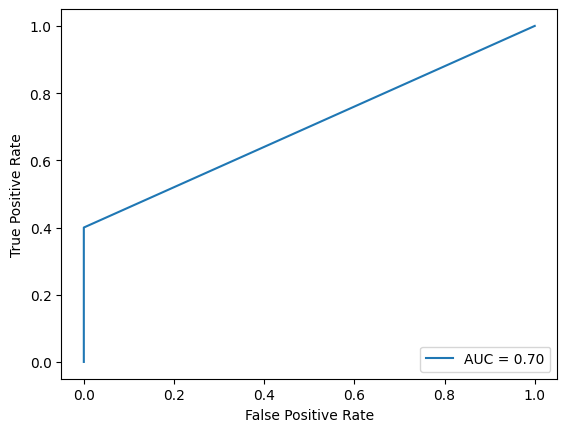

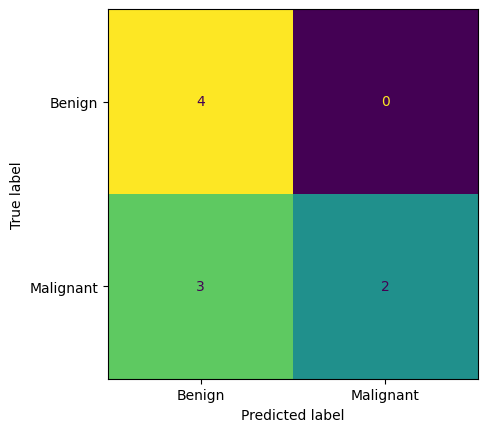

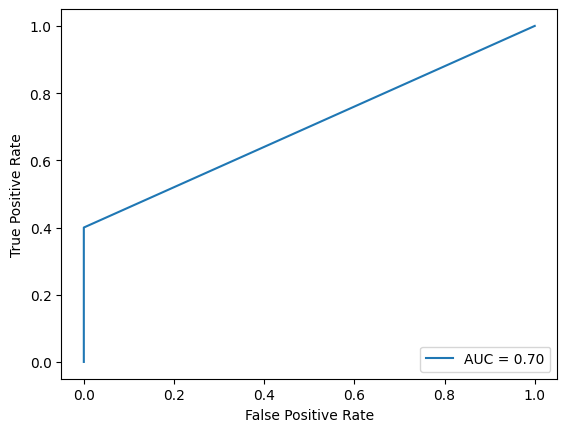

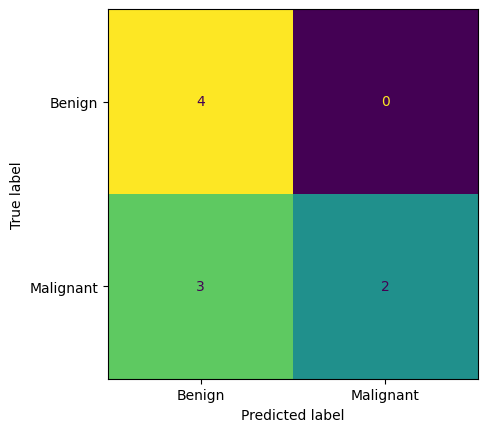

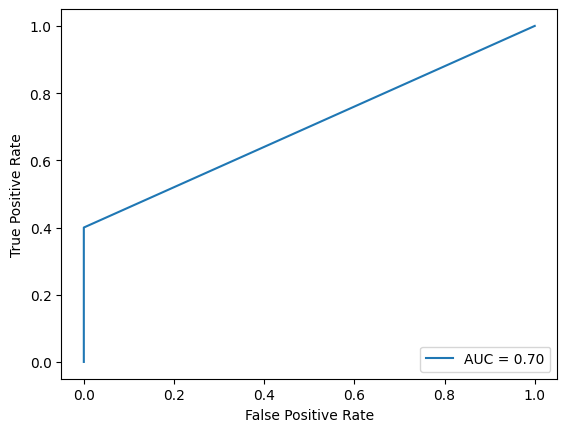

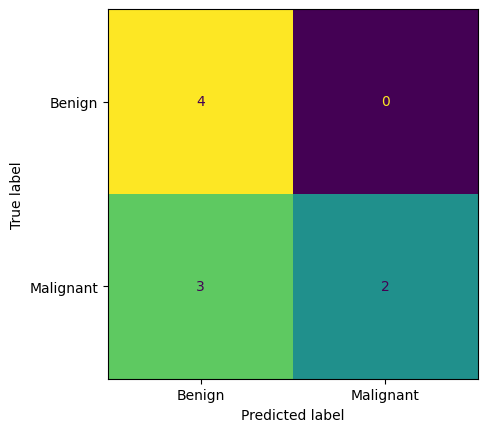

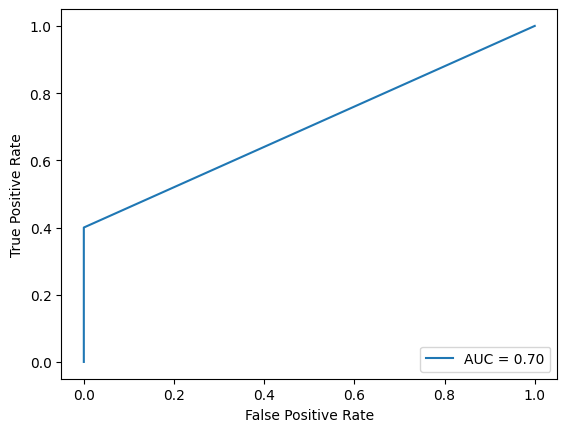

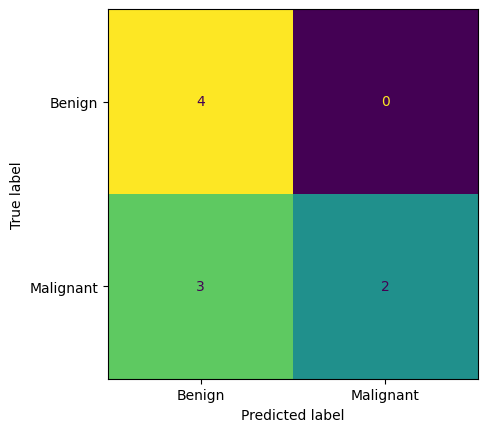

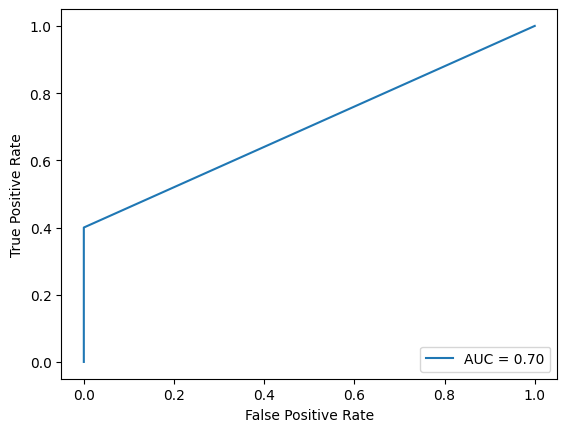

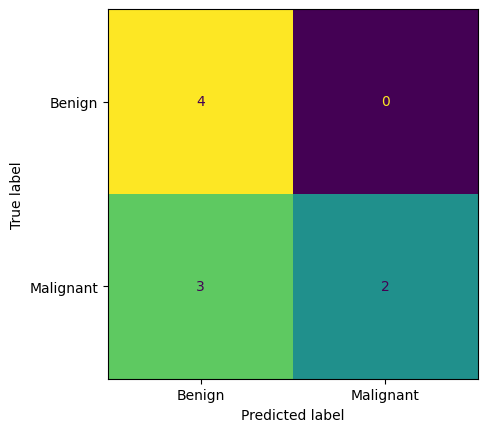

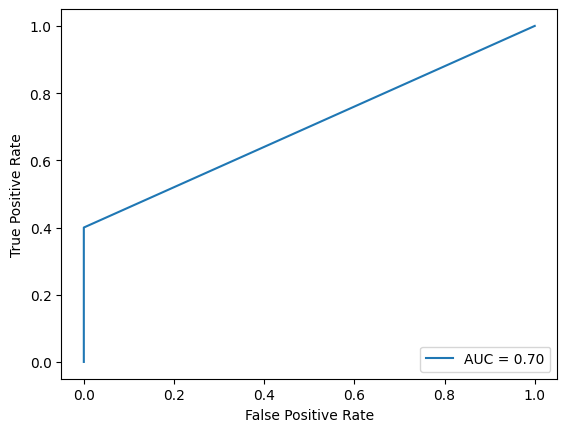

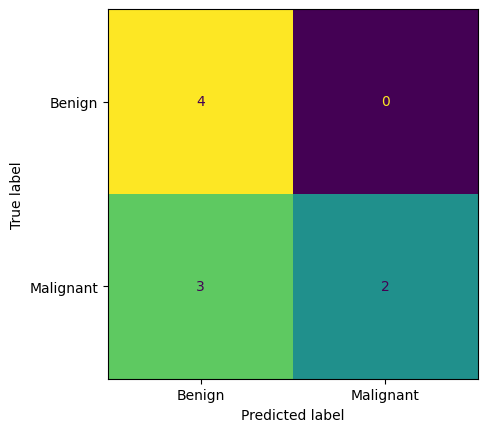

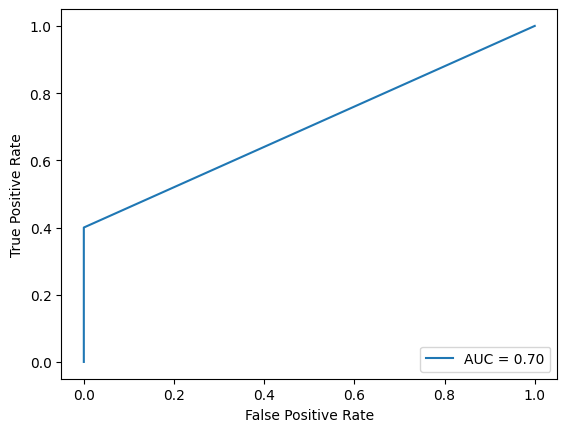

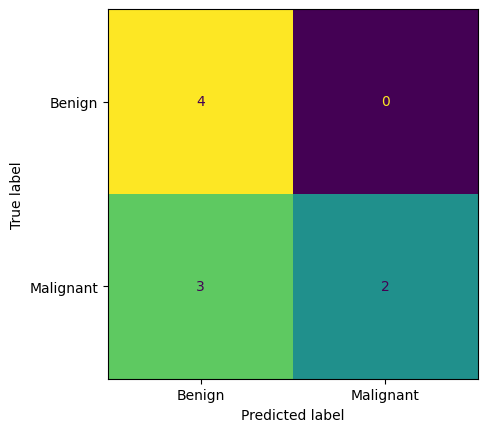

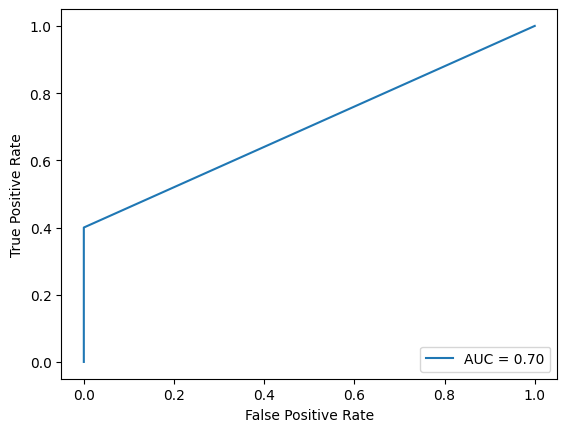

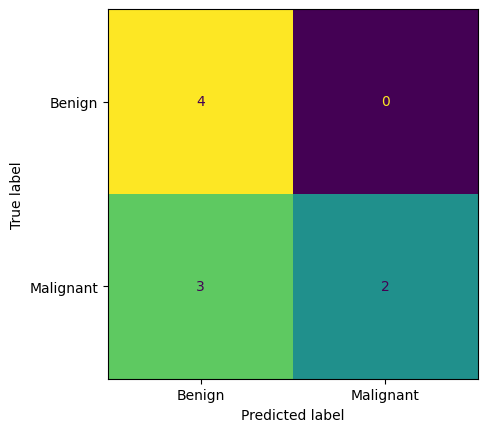

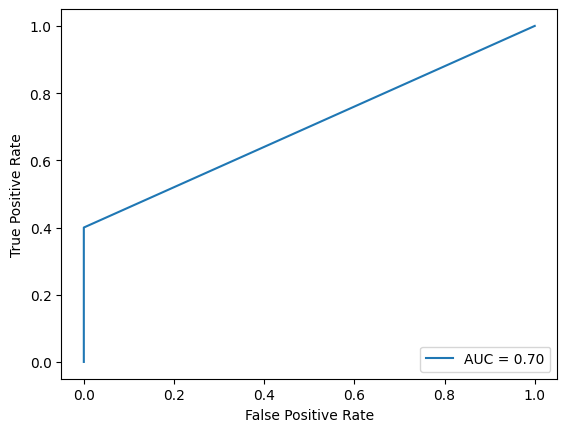

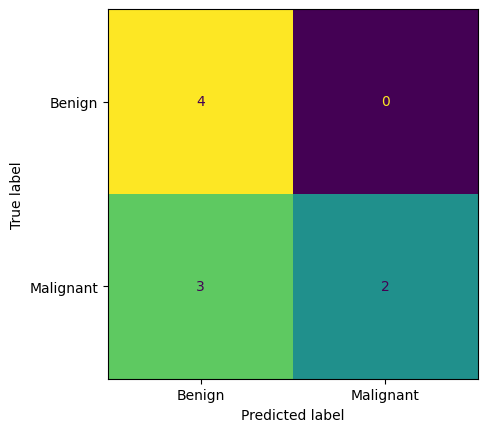

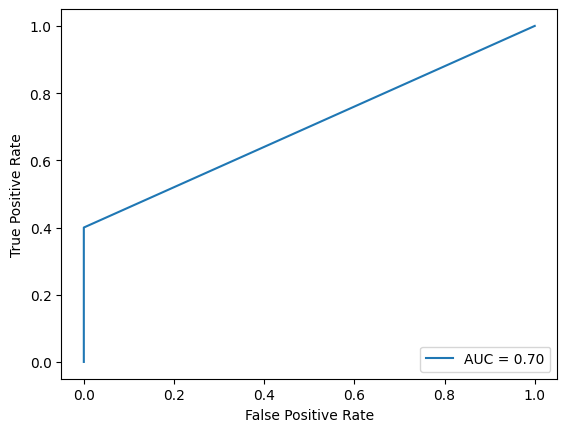

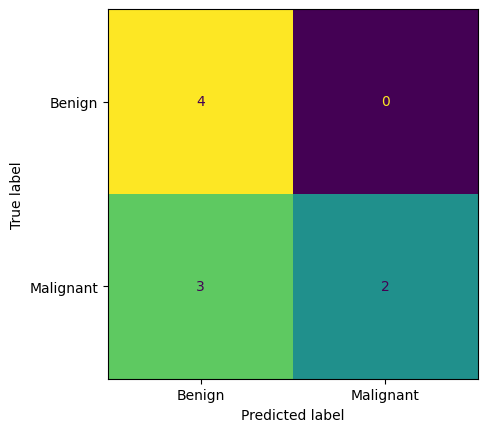

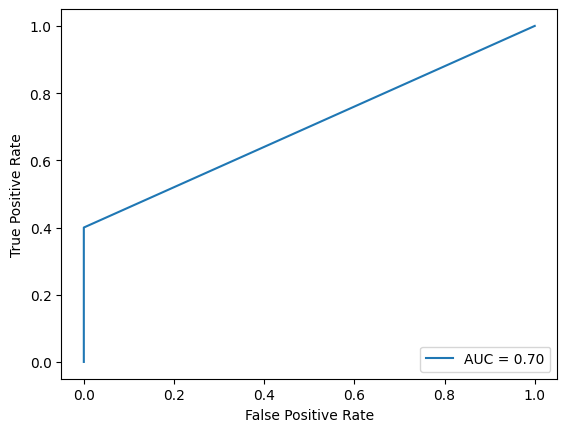

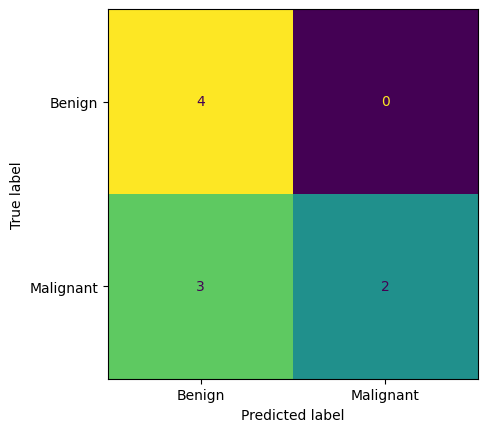

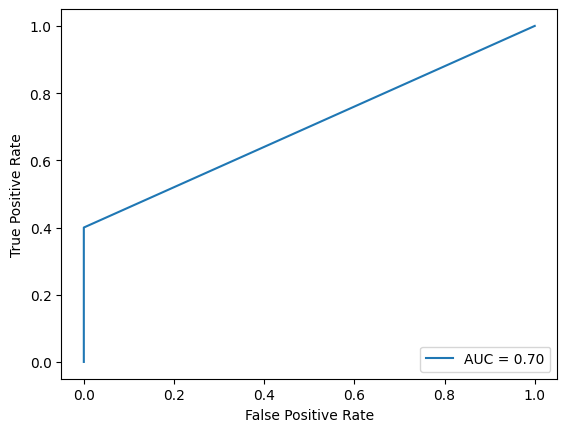

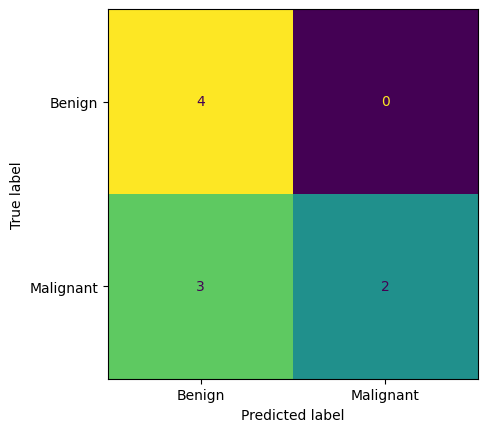

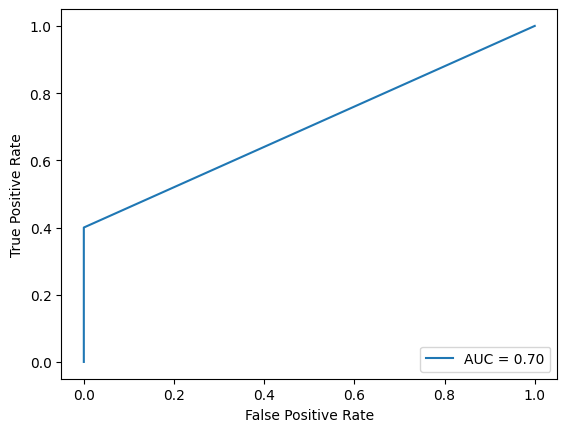

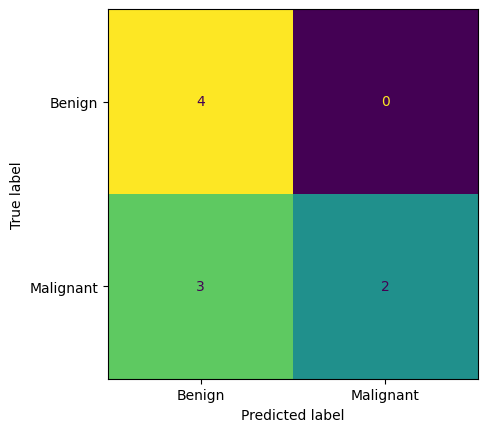

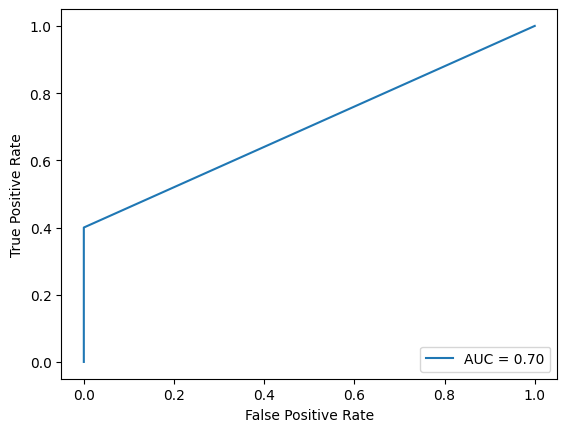

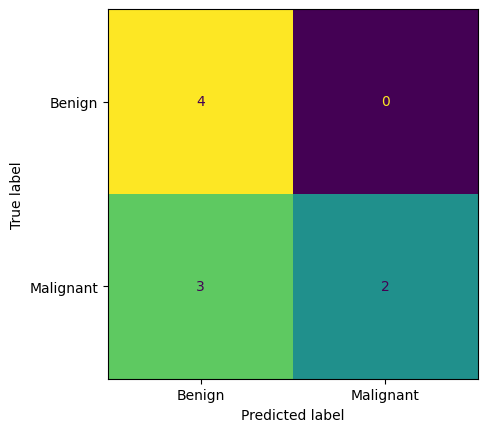

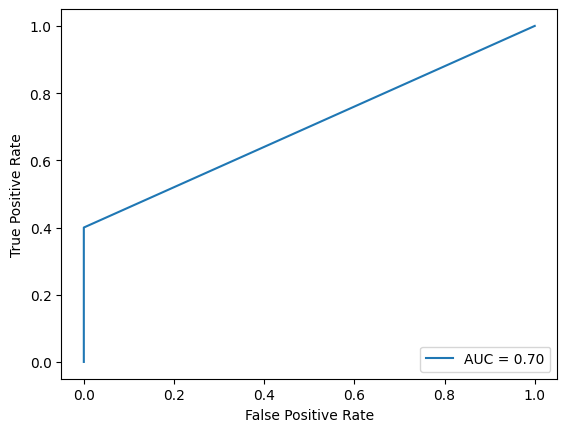

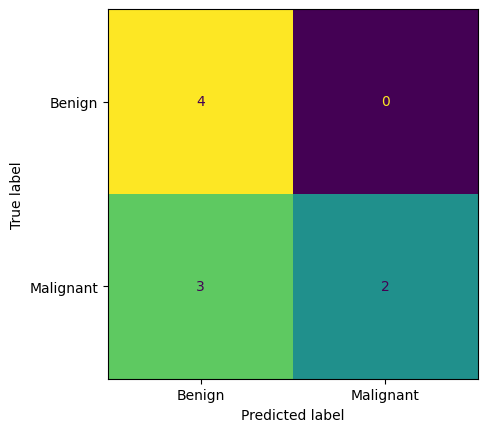

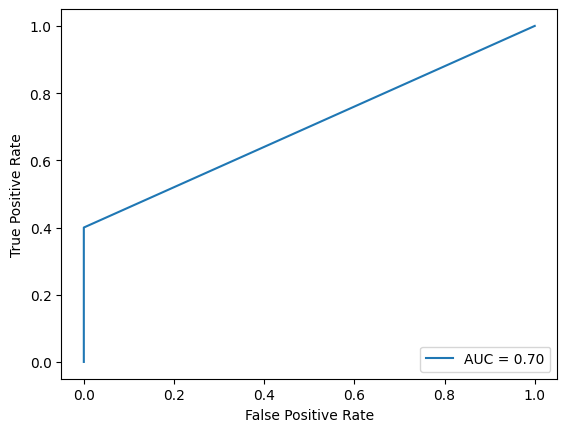

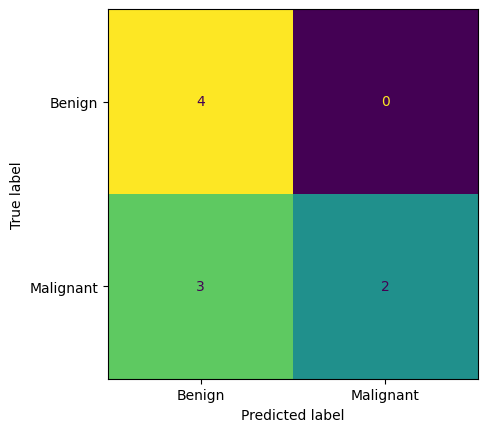

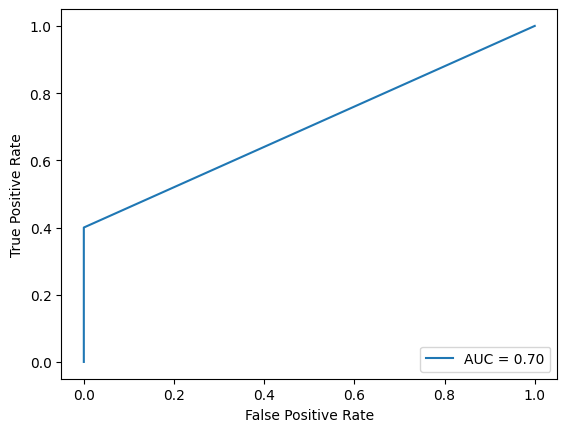

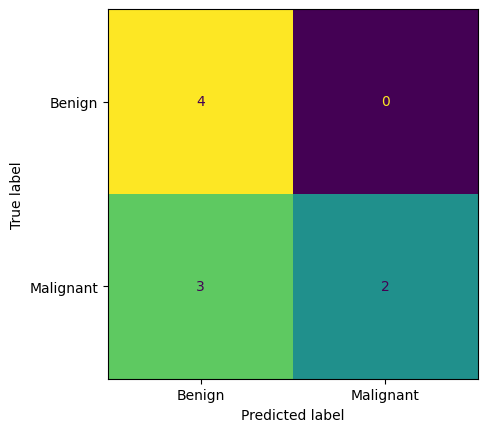

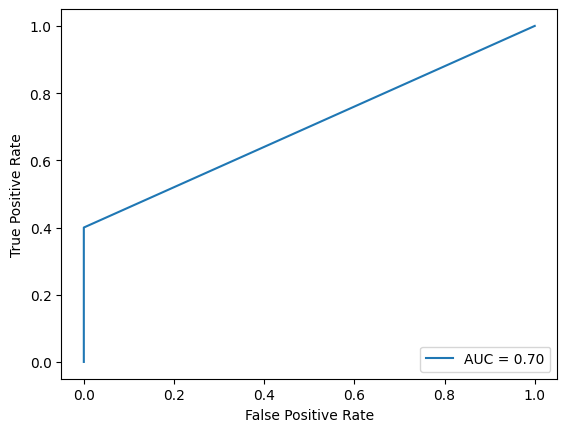

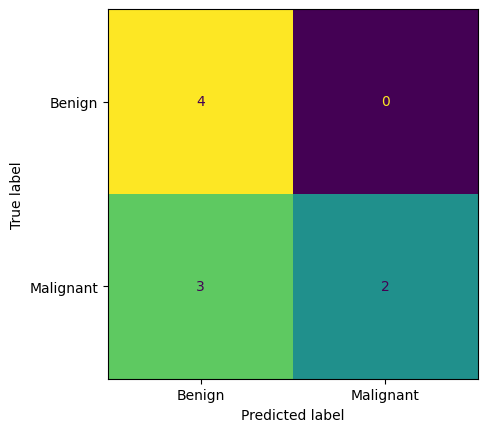

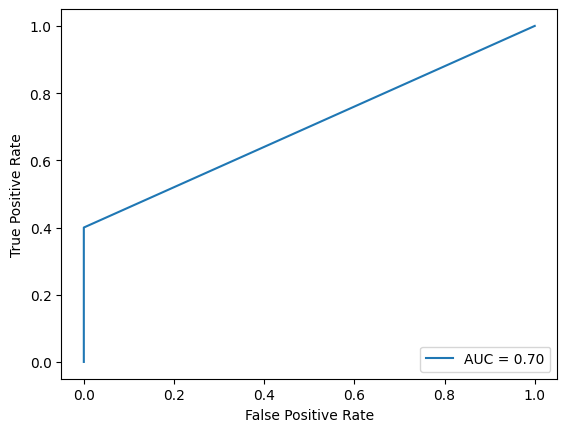

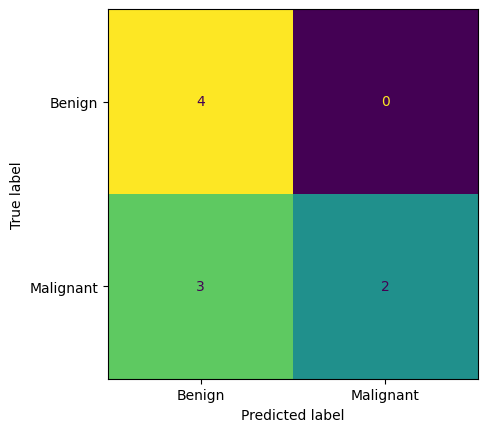

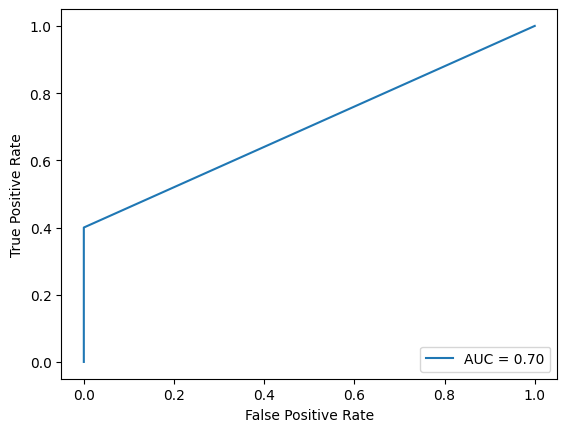

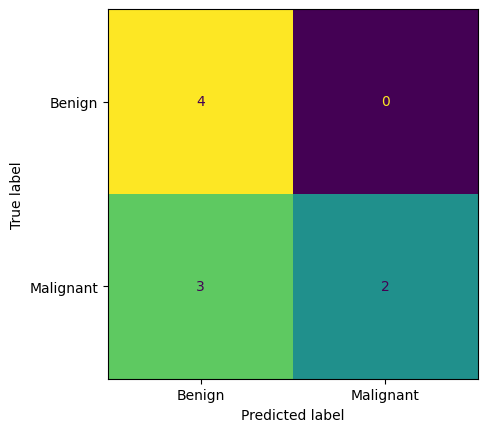

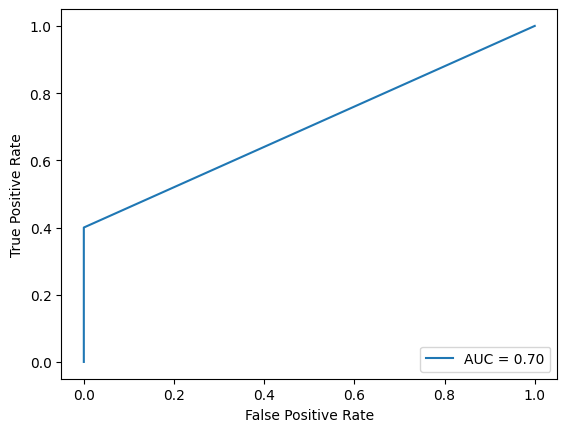

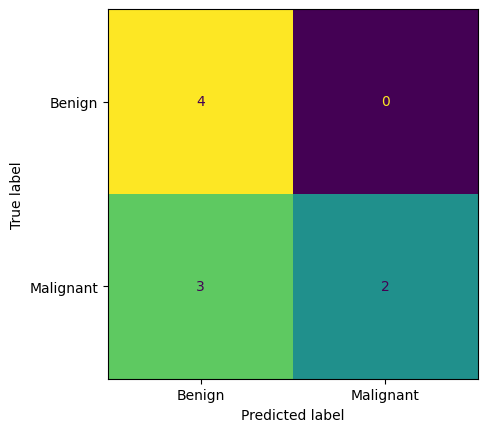

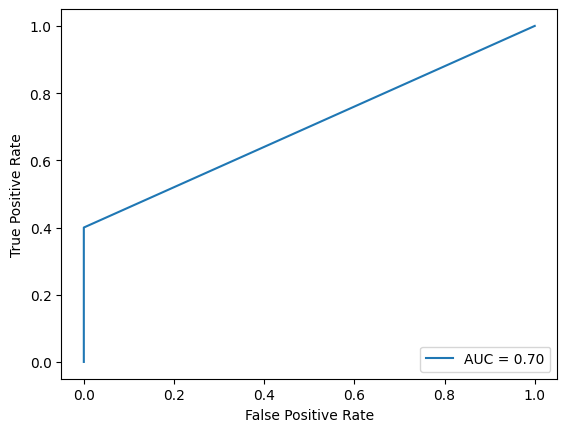

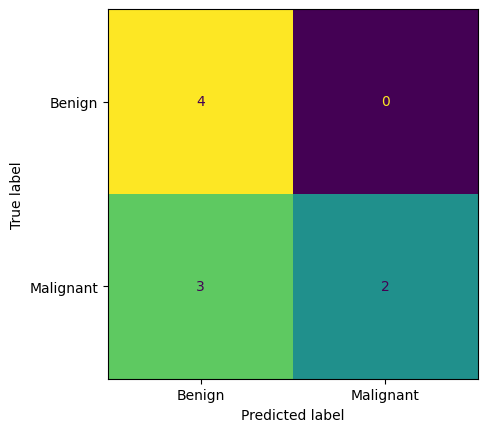

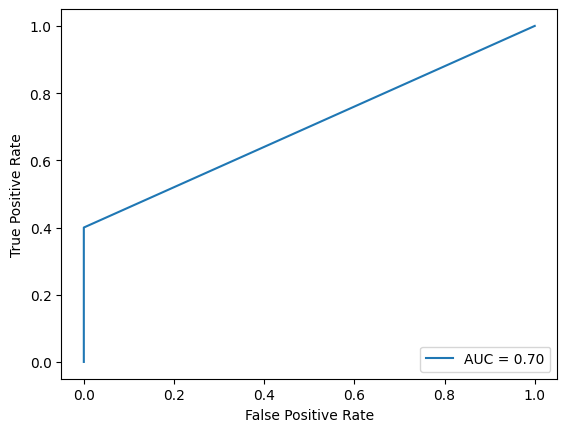

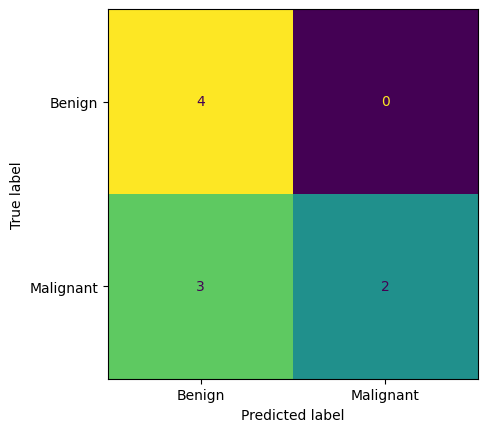

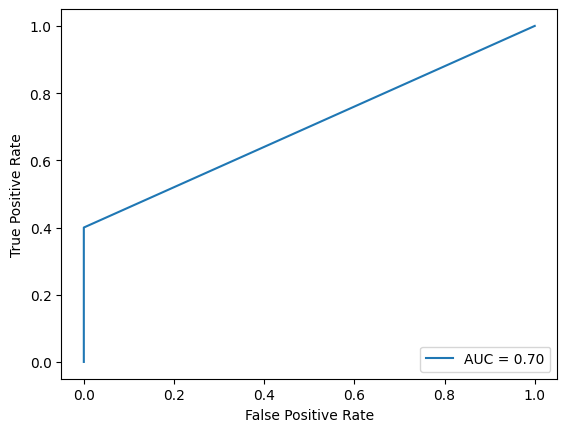

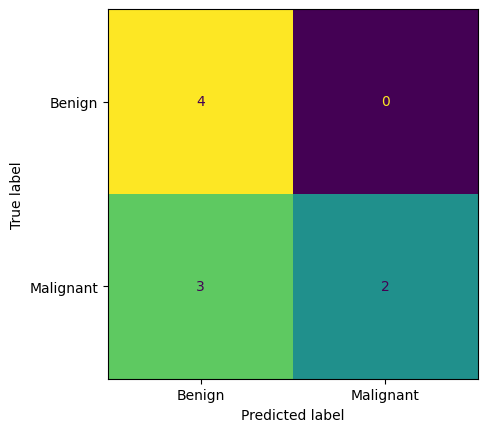

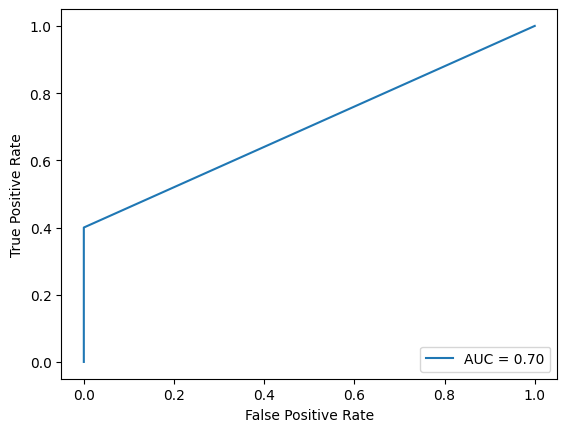

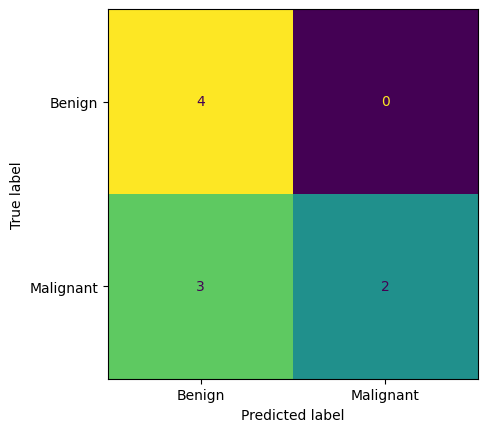

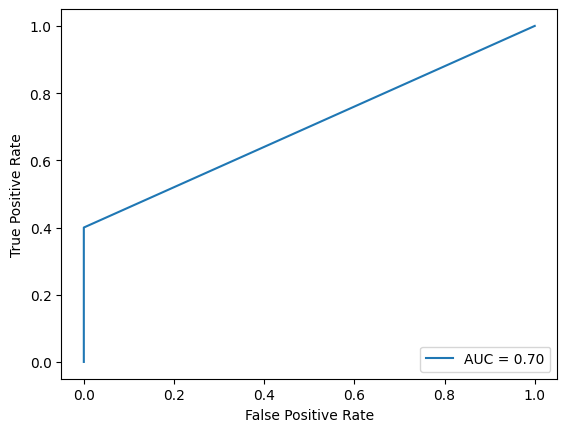

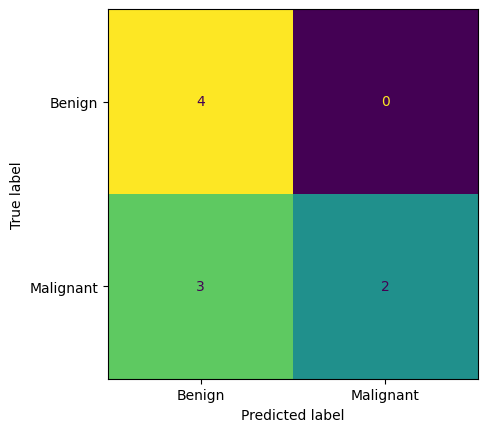

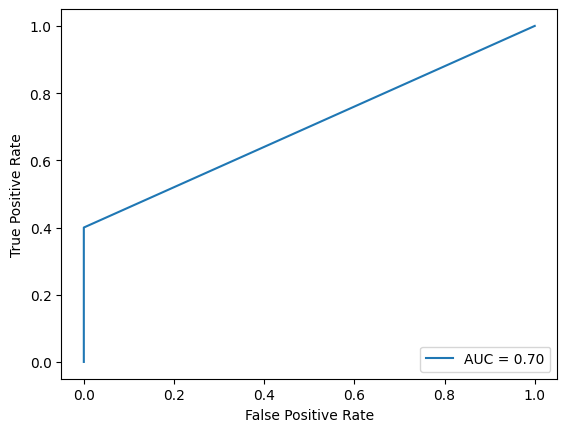

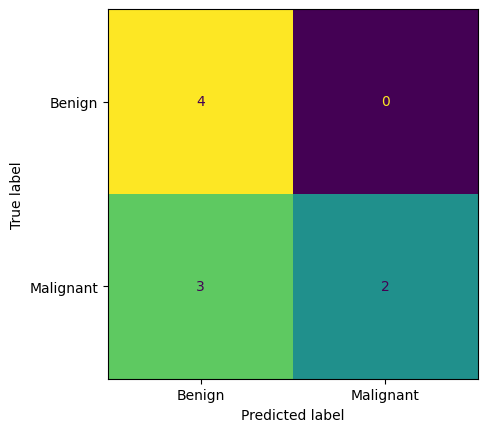

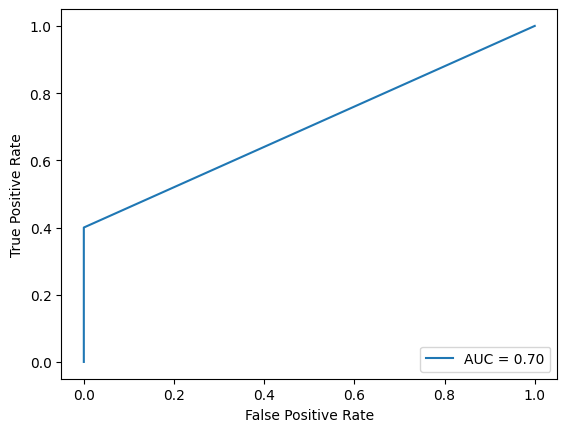

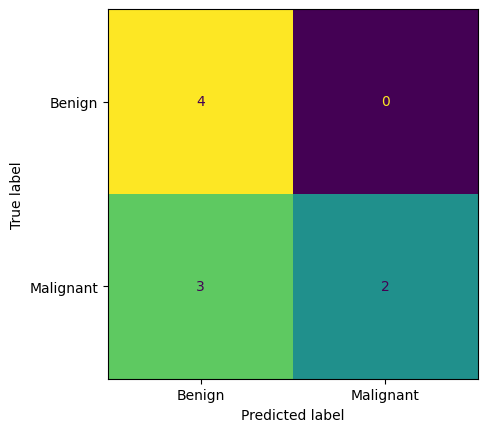

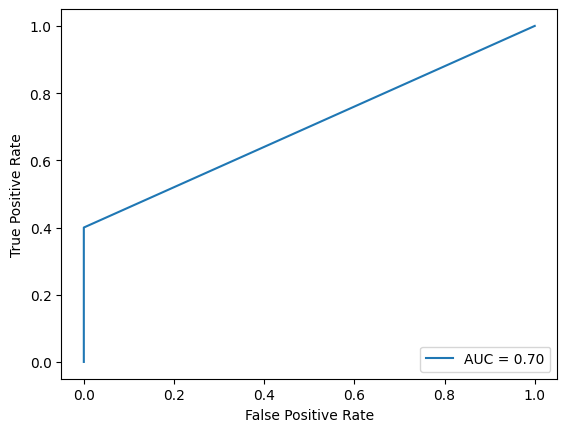

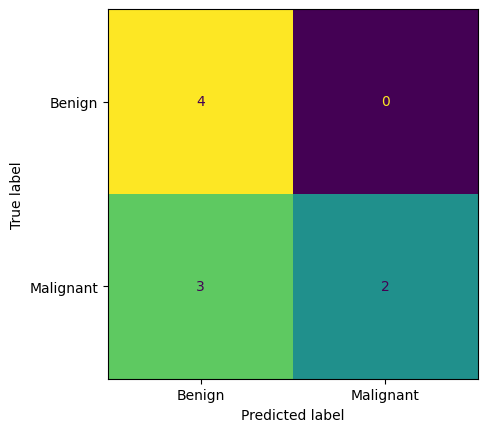

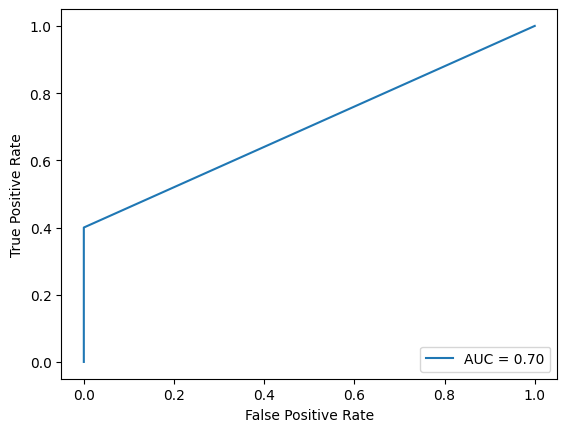

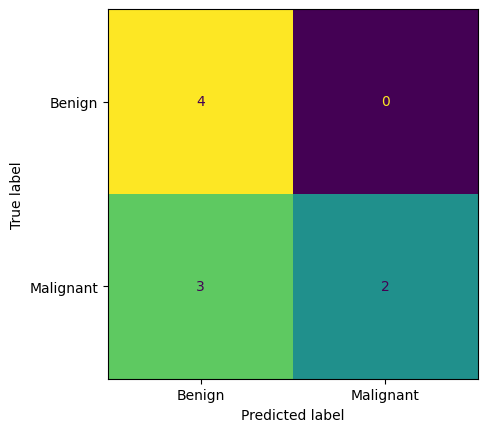

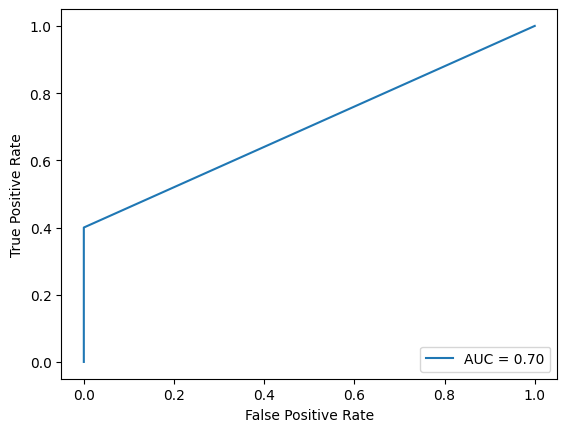

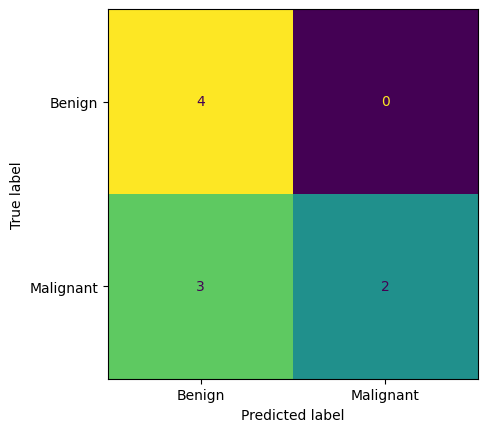

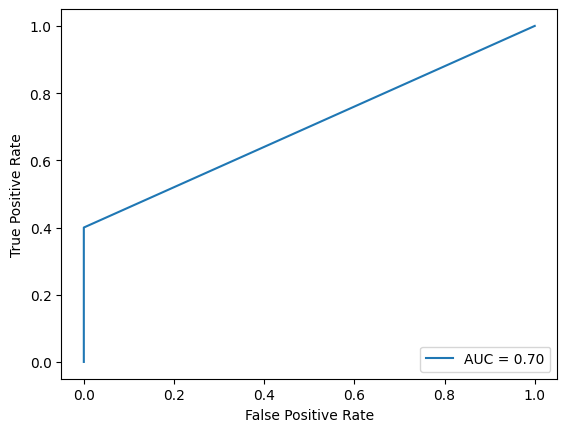

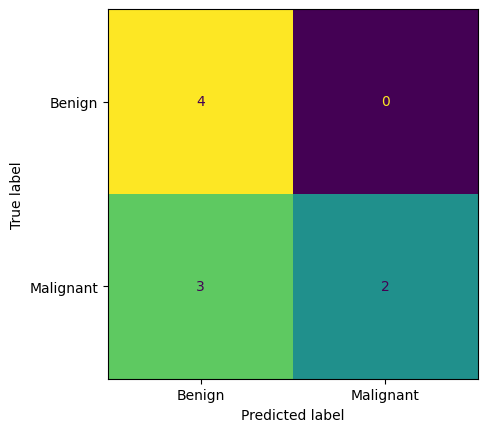

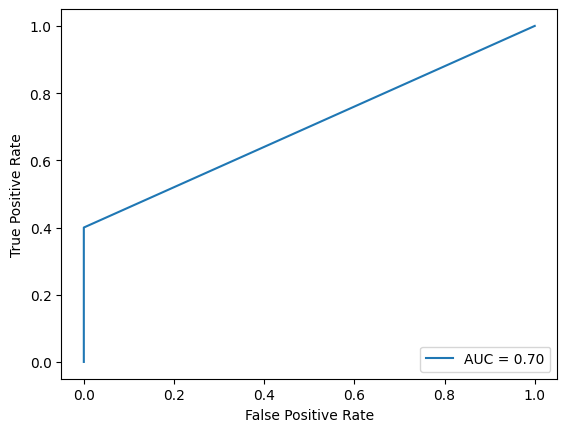

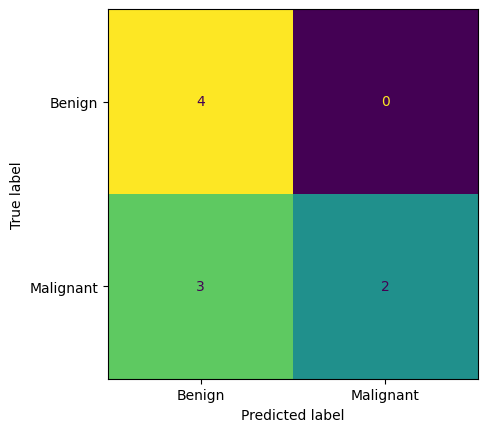

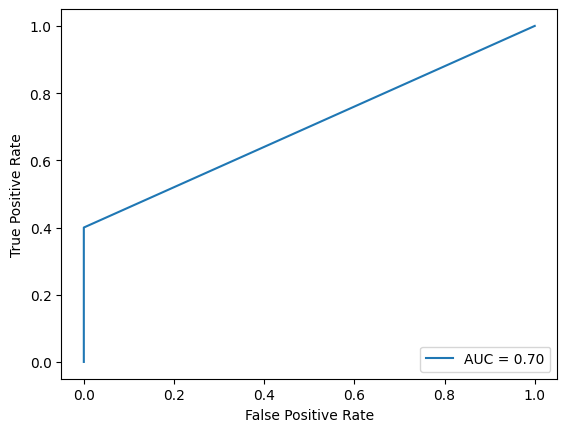

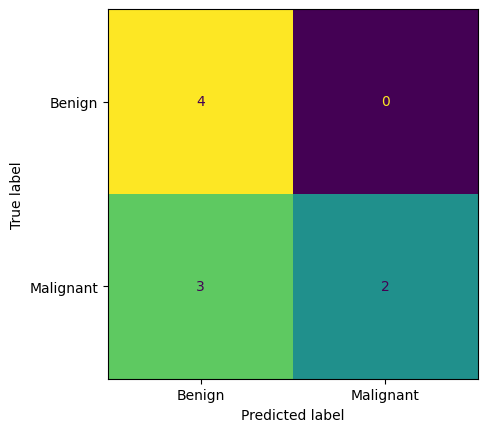

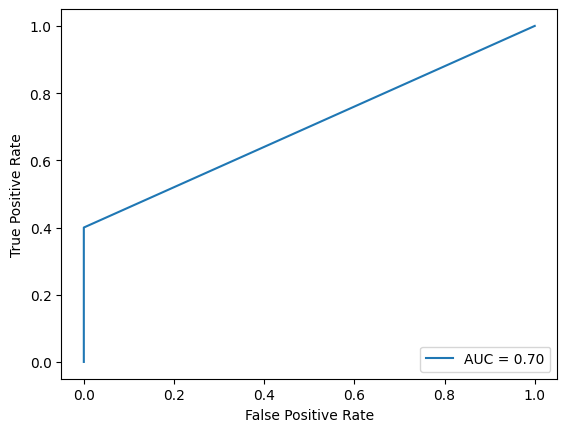

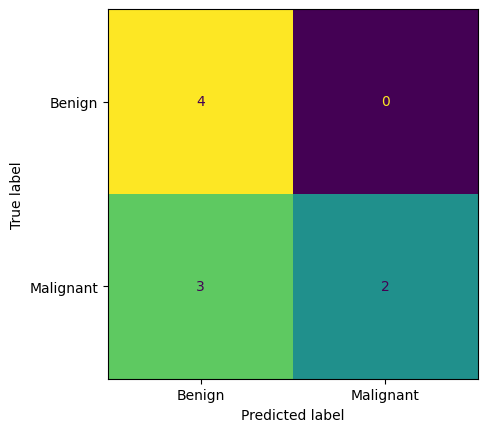

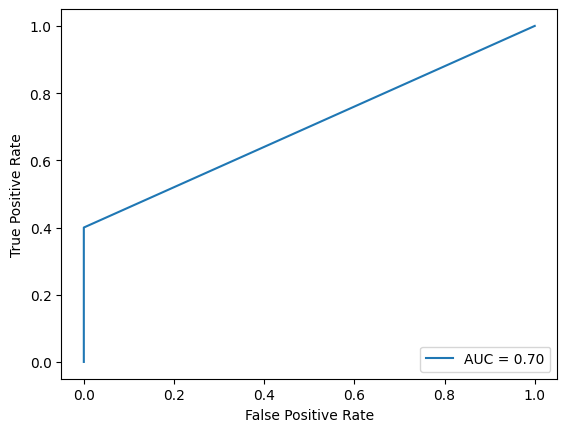

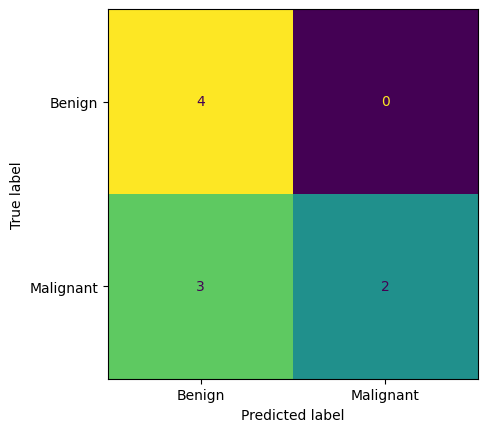

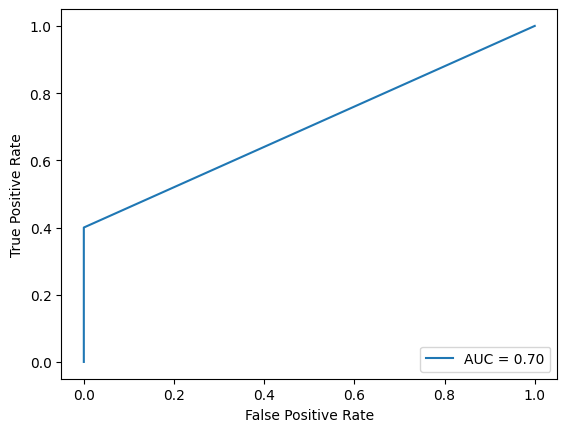

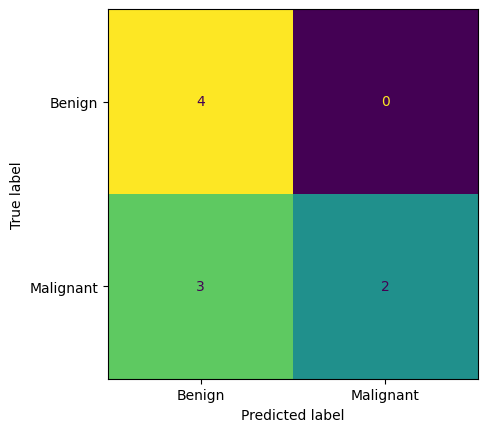

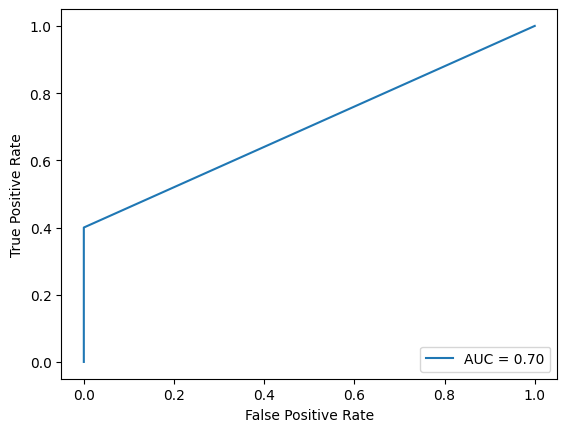

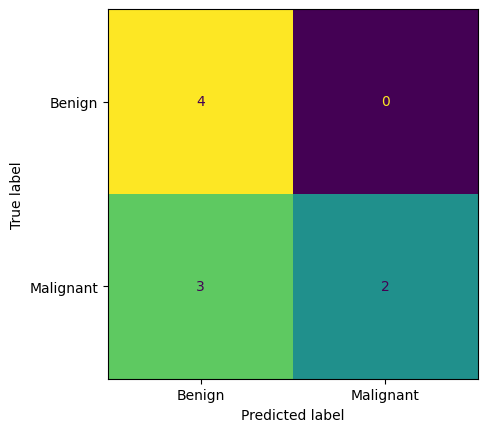

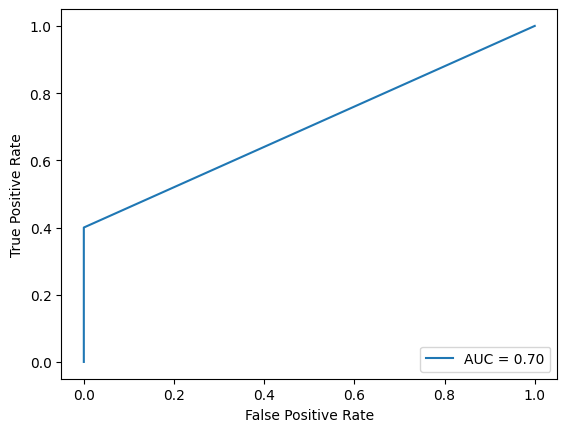

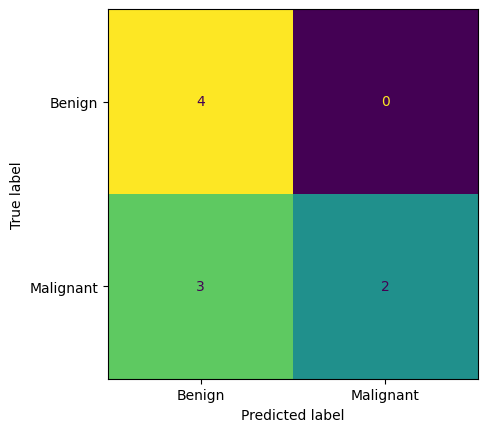

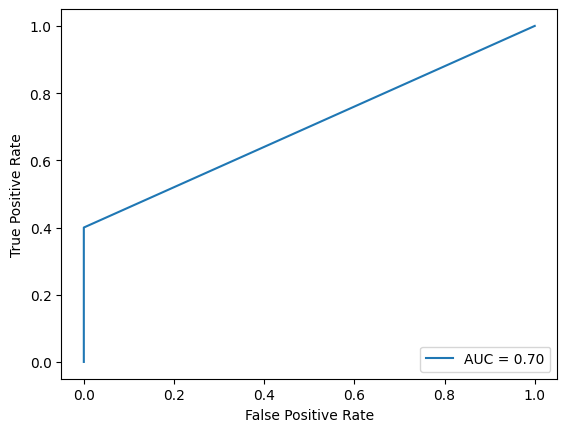

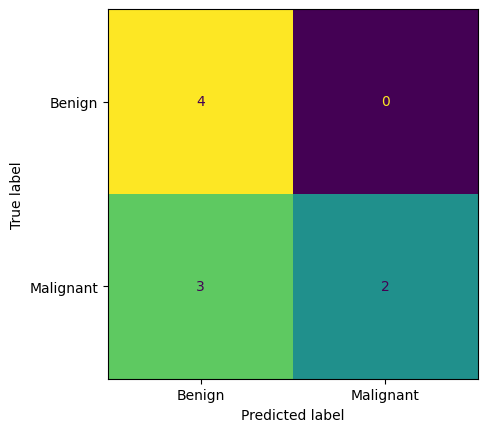

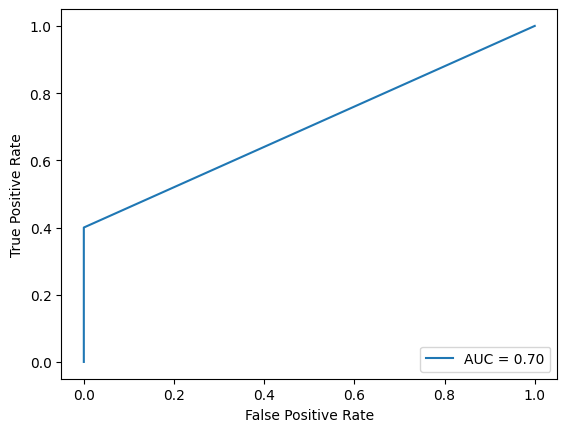

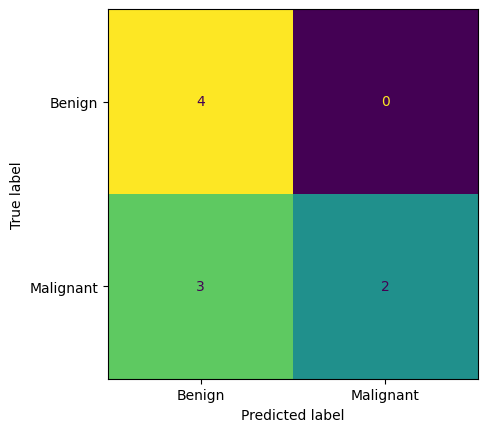

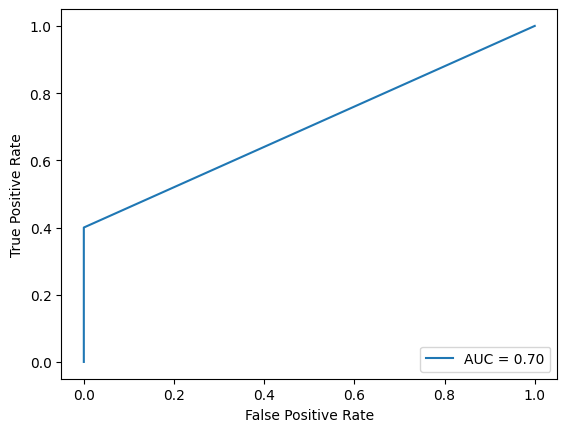

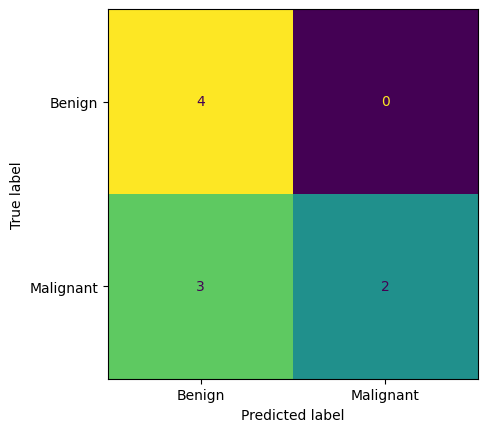

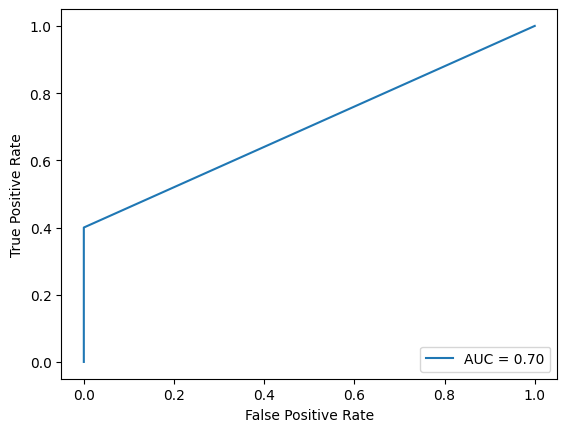

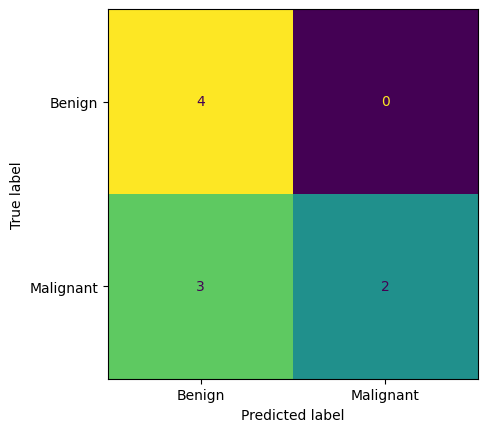

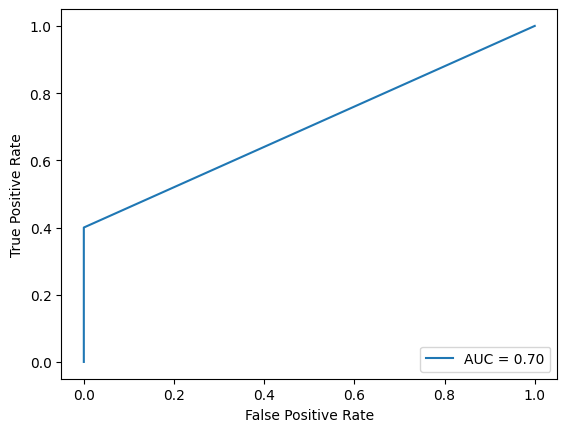

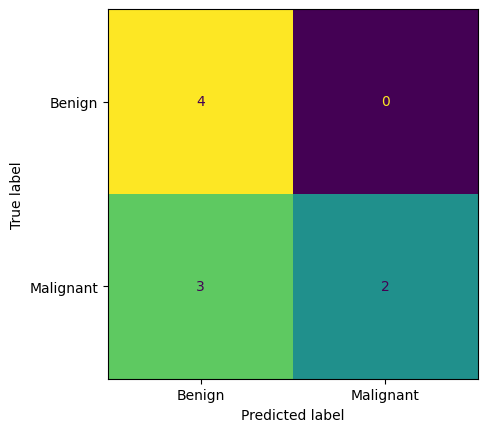

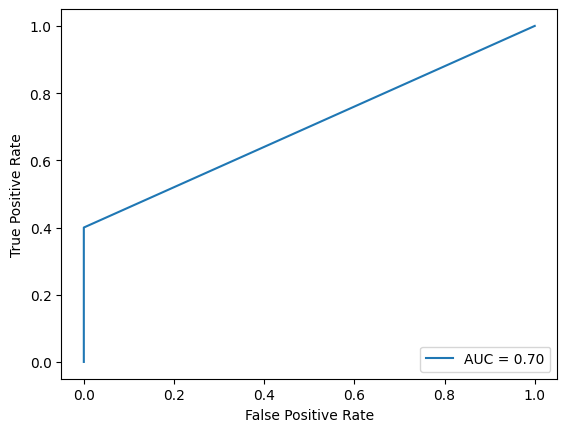

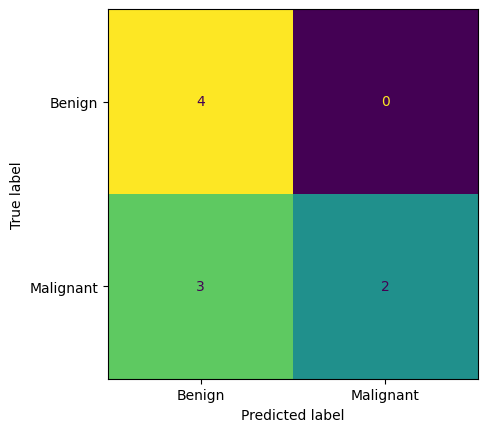

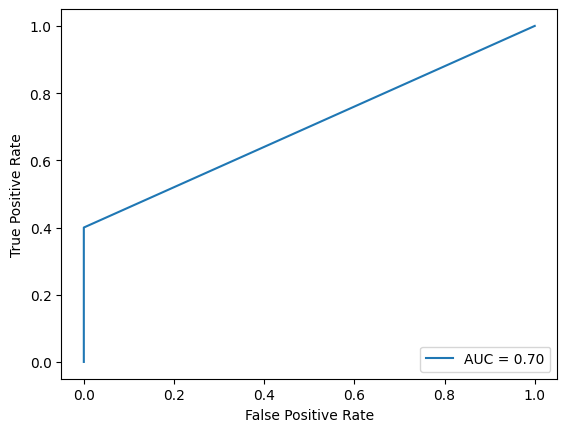

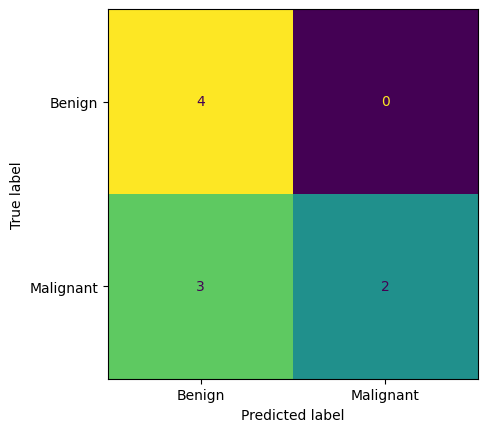

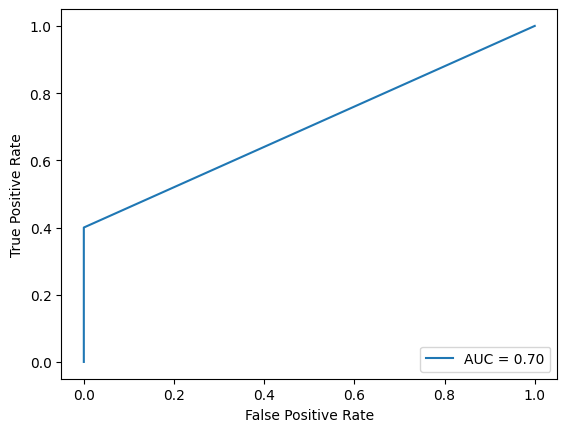

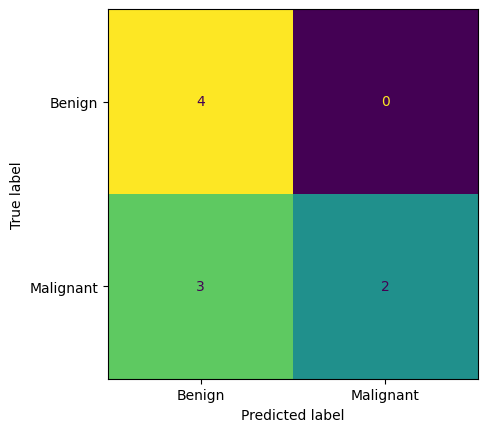

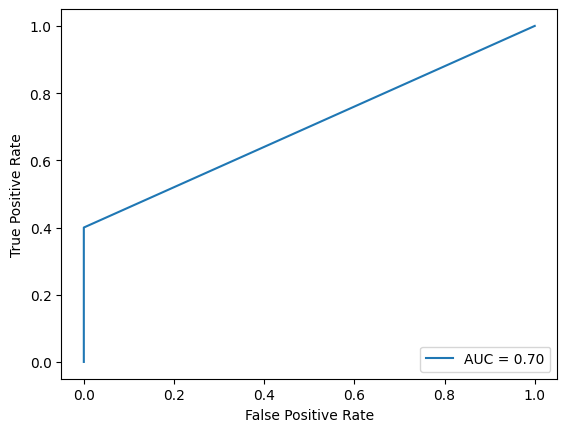

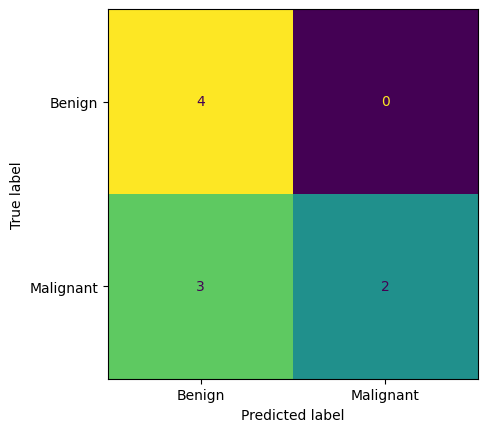

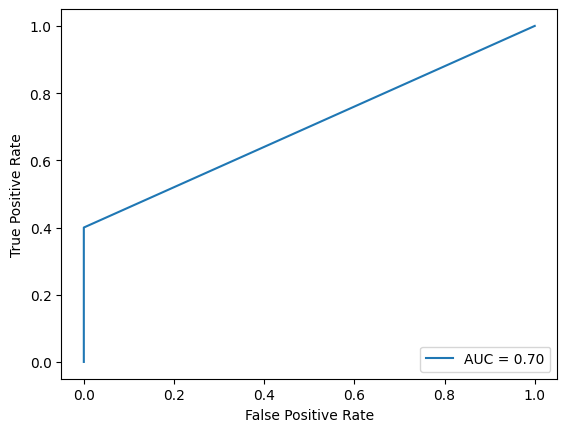

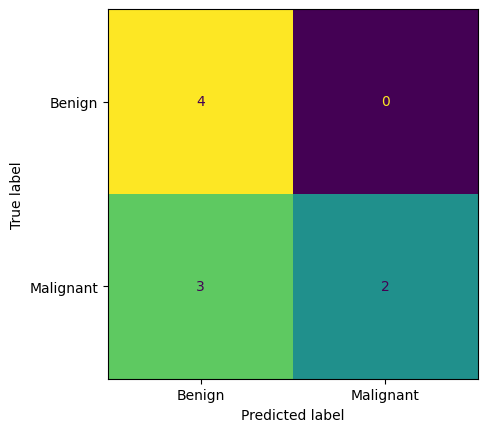

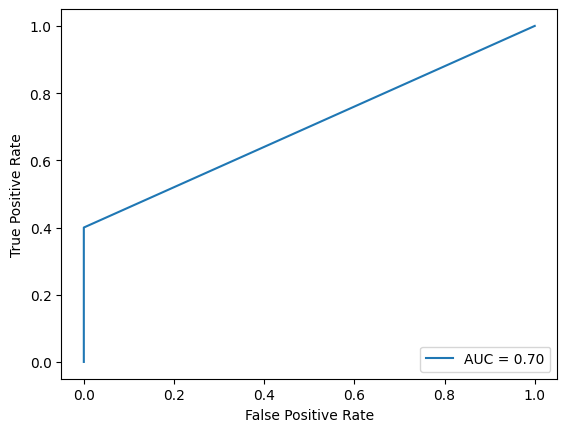

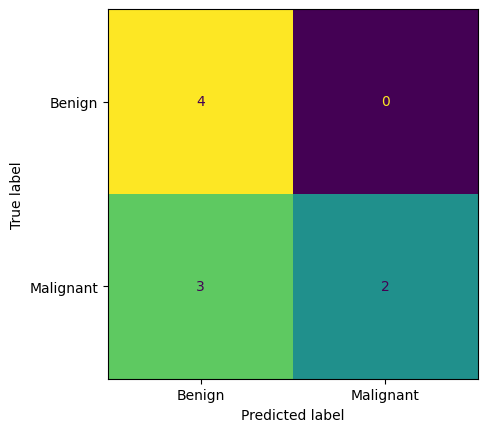

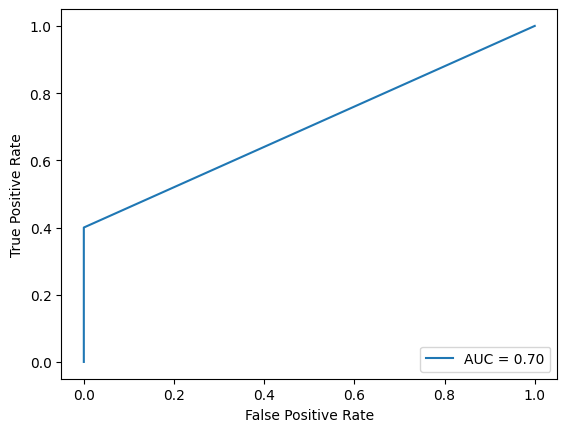

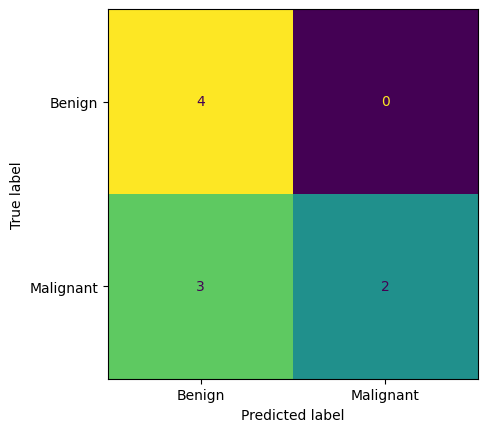

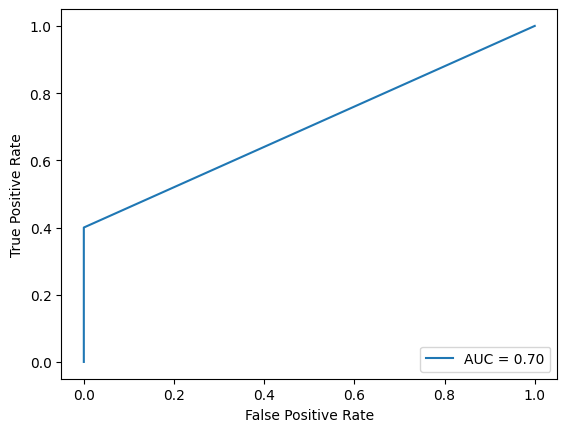

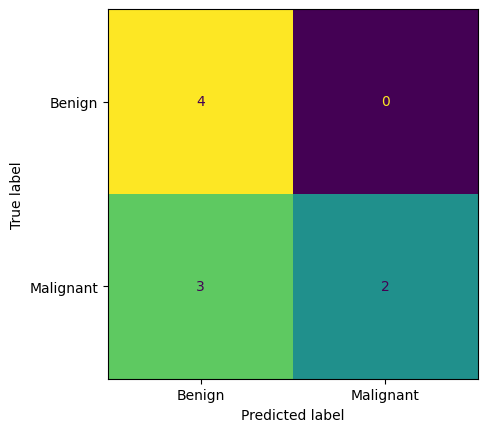

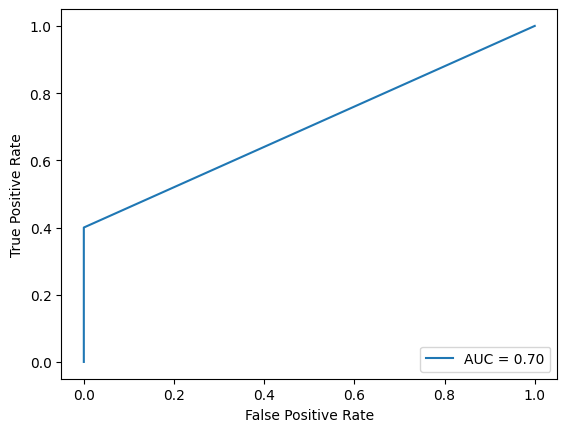

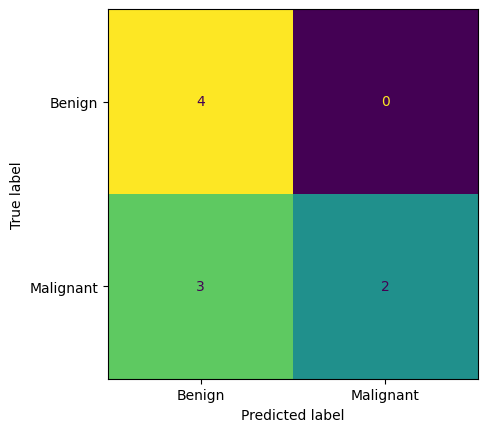

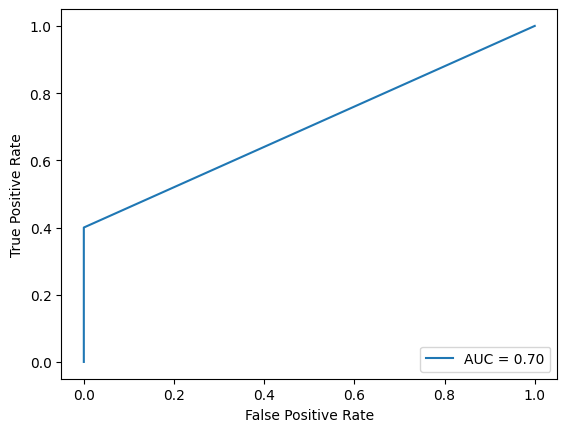

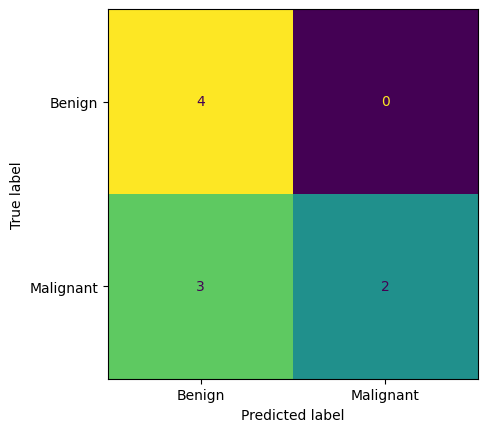

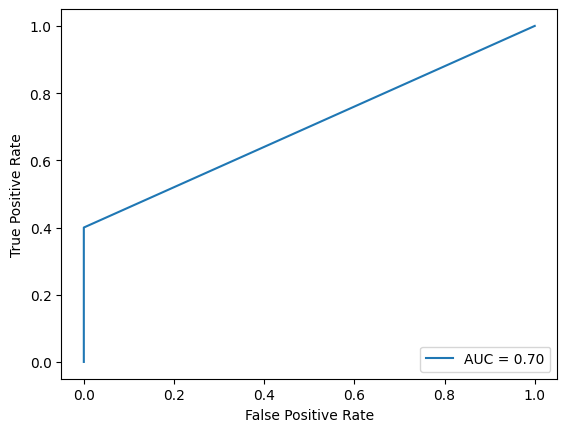

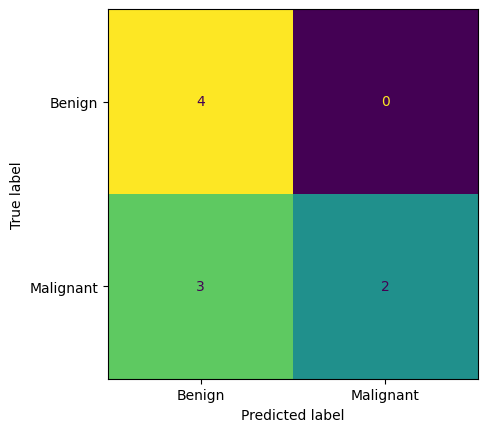

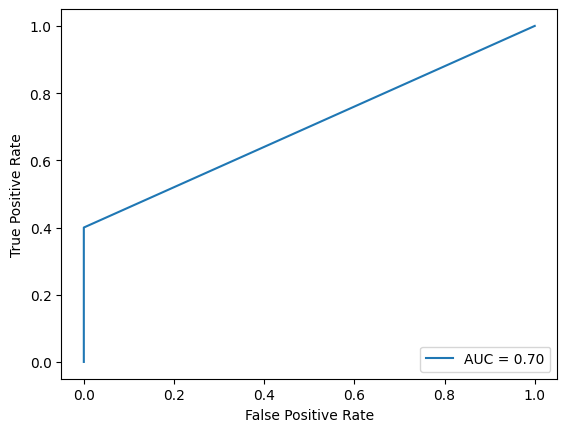

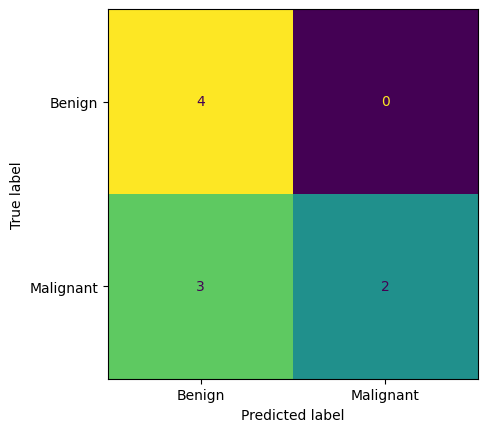

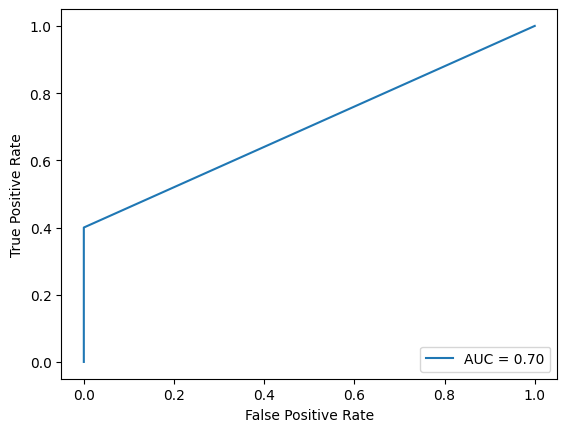

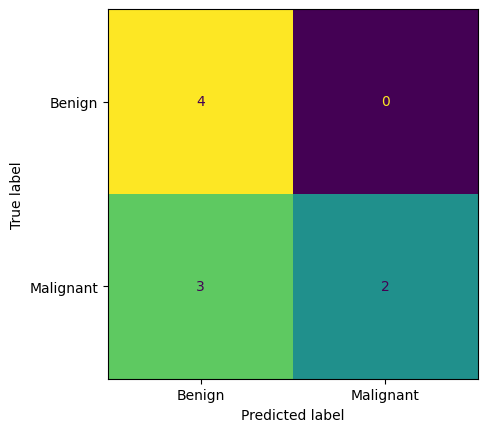

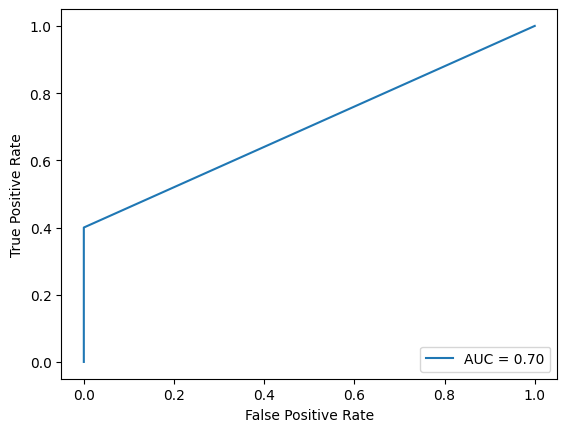

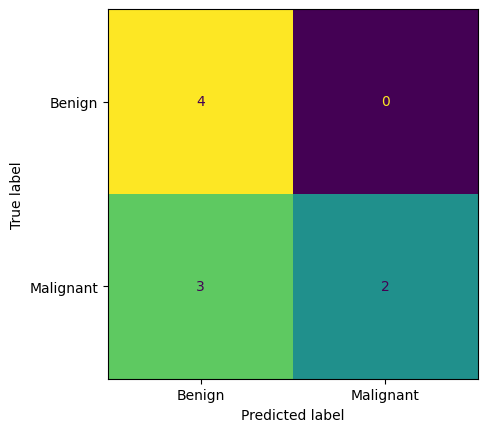

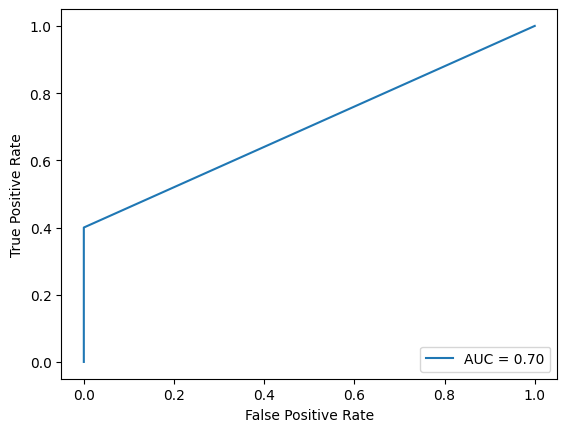

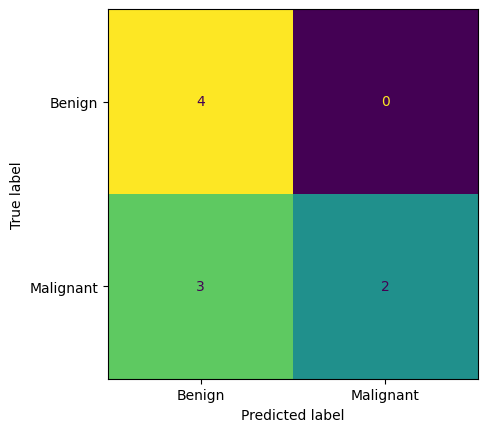

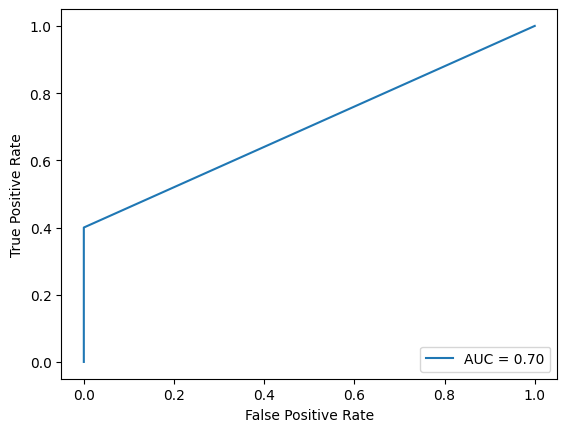

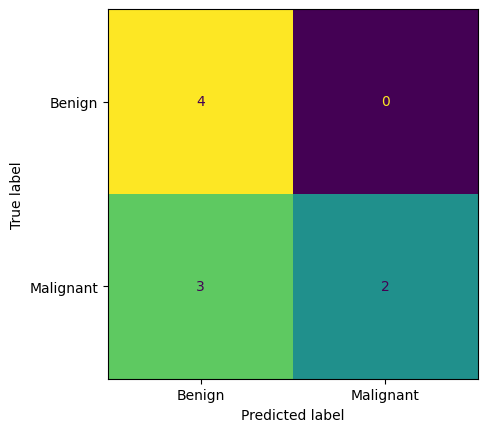

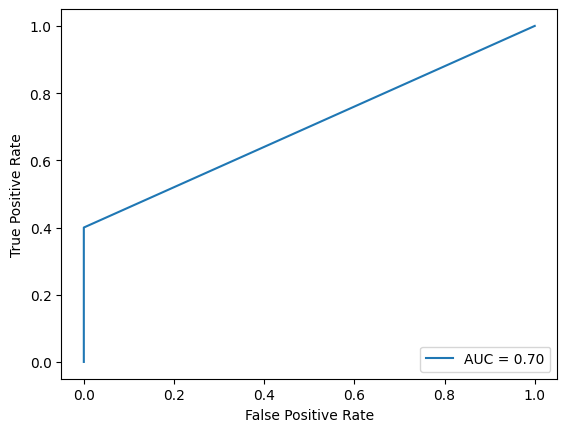

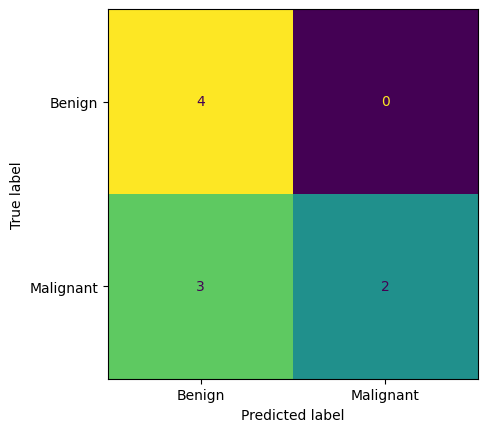

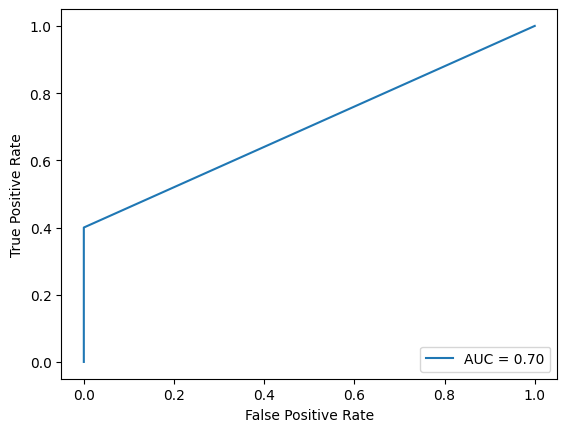

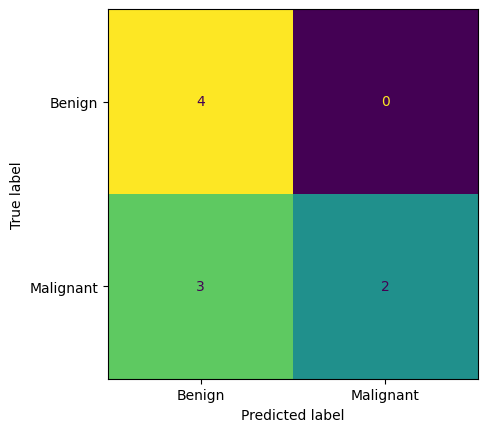

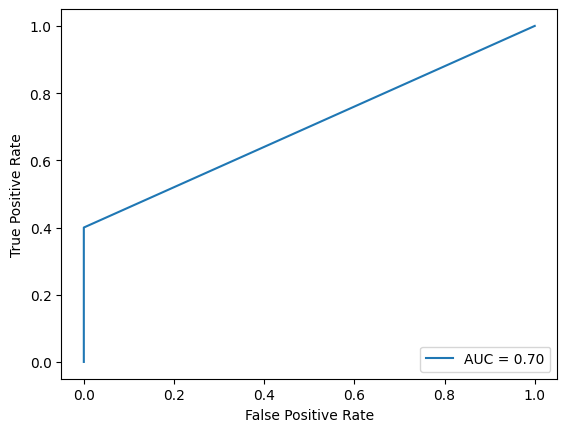

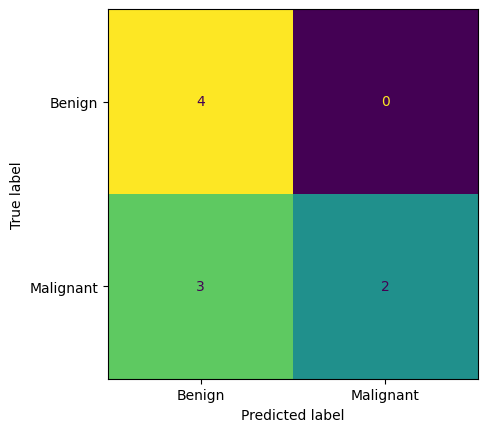

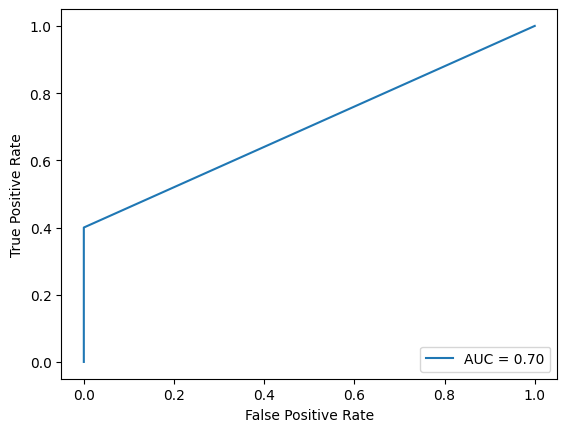

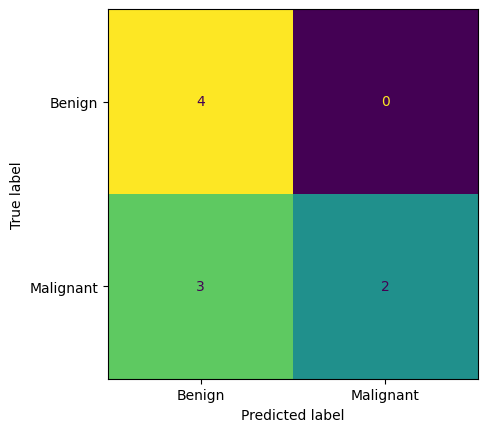

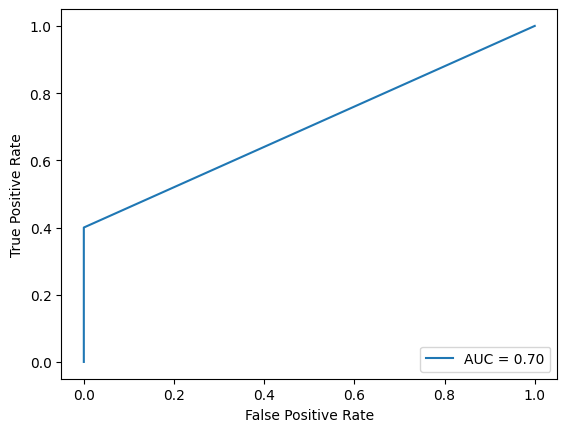

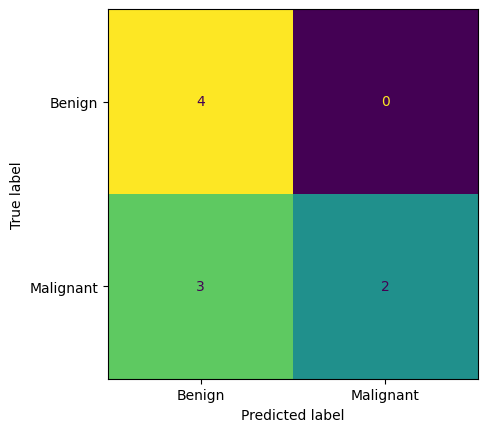

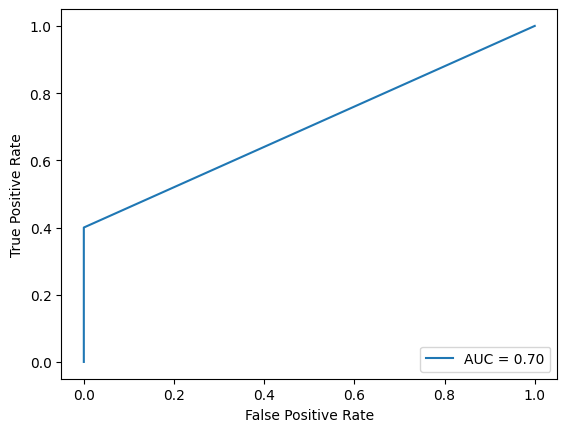

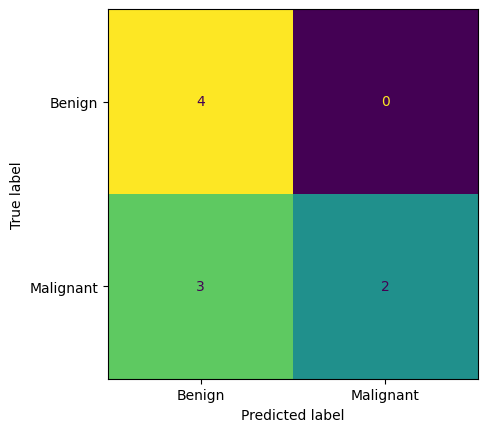

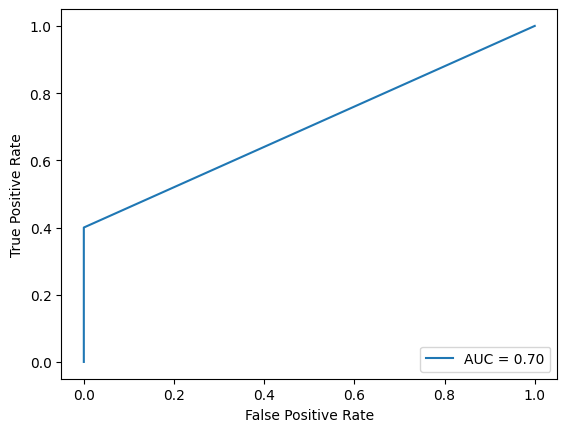

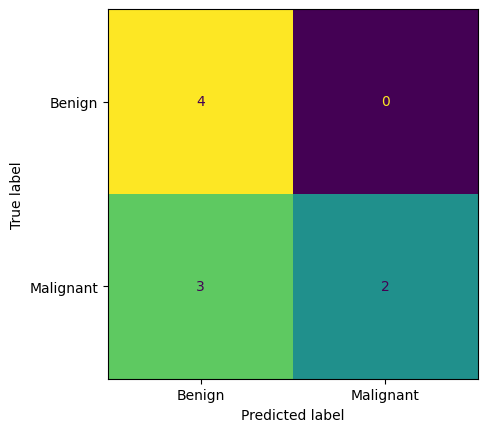

TrainOutput(global_step=150, training_loss=0.7949513188997904, metrics={'train_runtime': 3040.2211, 'train_samples_per_second': 3.799, 'train_steps_per_second': 0.049, 'total_flos': 7.160259840388301e+17, 'train_loss': 0.7949513188997904, 'epoch': 120.0})

In [ ]:
training_args = TrainingArguments(
    output_dir="_" # <-- SET YOUR HUGGINGFACE MODEL DIRECTORY TO STORE CHECKPOINTS
    f"_", # <-- SET YOUR MODEL NAME 
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    learning_rate=1e-5, 
    optim="adamw_torch",
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=50,
    warmup_ratio=0.1,
    logging_steps=1,
    # resume_from_checkpoint='checkpoint-XXXX', # <-- SET THE CHECKPOINT TO RESUME
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

trainer.train()

Evaluate best model

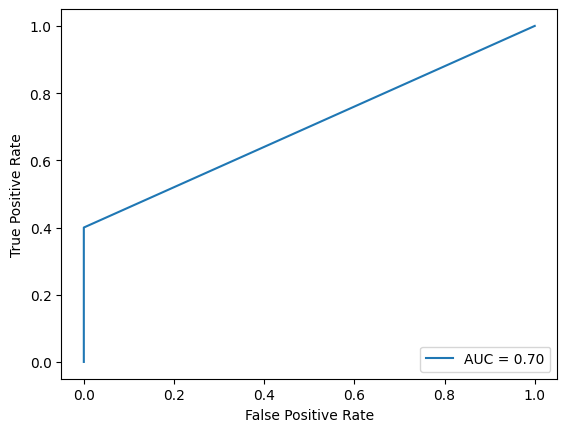

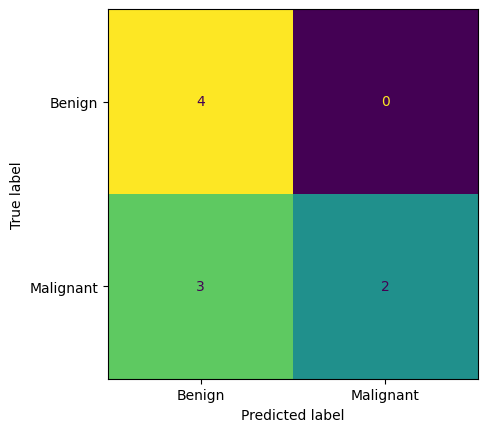

***** eval metrics *****
  epoch                     =      120.0
  eval_NPV                  =        1.0
  eval_accuracy             =     0.6667
  eval_auc                  =        0.7
  eval_f1                   =     0.7273
  eval_loss                 =     0.6454
  eval_precision (PPV)      =     0.5714
  eval_recall (sensitivity) =        1.0
  eval_runtime              = 0:00:07.16
  eval_samples_per_second   =      1.256
  eval_specificity          =        0.4
  eval_steps_per_second     =       0.14


In [ ]:
val_metrics = trainer.evaluate()
# some nice to haves:
trainer.log_metrics("eval", val_metrics)
trainer.save_metrics("eval", val_metrics)

Test the best model

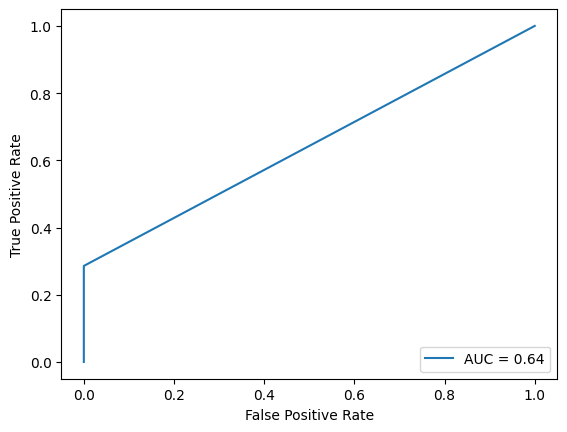

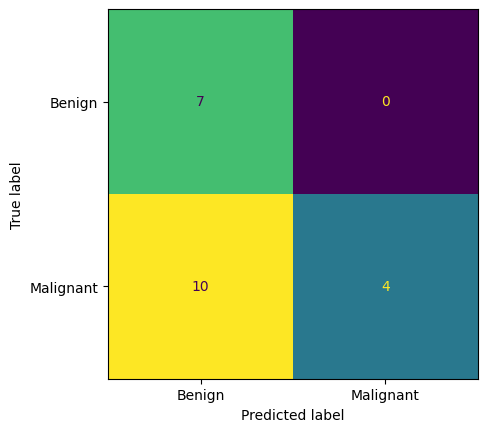

PredictionOutput(predictions=array([[ 0.2597277 , -0.32406783],
       [ 0.2048988 , -0.27768496],
       [ 0.94844234,  0.31822512],
       [ 0.24180375, -0.19250652],
       [ 0.8030522 ,  0.17912614],
       [ 0.5364313 , -0.16348481],
       [ 0.6858044 ,  0.39709178],
       [ 0.3379906 ,  0.361721  ],
       [ 0.3522587 , -0.0316183 ],
       [ 0.3422347 , -0.7664381 ],
       [ 0.1209916 , -0.27239594],
       [ 0.354575  , -0.09368742],
       [ 0.41961077, -0.4084053 ],
       [ 0.7143835 ,  0.2958503 ],
       [ 0.63579017,  0.5084771 ],
       [ 0.2637929 ,  0.49081582],
       [ 0.54800856,  0.10175402],
       [ 0.3980536 ,  0.04945485],
       [ 0.40882418,  0.13298908],
       [-0.29625002,  0.3647053 ],
       [-0.11468764,  0.03044522]], dtype=float32), label_ids=array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), metrics={'test_loss': 0.7254611253738403, 'test_accuracy': 0.5238095238095238, 'test_f1': 0.5833333333333334, 'test_precision (PPV)': 0.4

In [ ]:
model.eval()

test_metrics = trainer.predict(test_ds)
test_metrics

Log training history

In [ ]:
train_log_history=trainer.state.log_history

Write to csv and plot learning curves

In [ ]:
import csv

with open('losses.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for element in train_log_history:
        writer.writerow([element])

In [ ]:
#read csv 
import csv

with open('losses.csv', 'r', newline='') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        print(row)

["{'loss': 0.8749, 'learning_rate': 6.666666666666666e-09, 'epoch': 0.8, 'step': 1}"]
["{'eval_loss': 0.6969725489616394, 'eval_accuracy': 0.5555555555555556, 'eval_f1': 0.6666666666666666, 'eval_precision (PPV)': 0.5, 'eval_recall (sensitivity)': 1.0, 'eval_specificity': 0.2, 'eval_NPV': 1.0, 'eval_auc': 0.6, 'eval_runtime': 6.0361, 'eval_samples_per_second': 1.491, 'eval_steps_per_second': 0.166, 'epoch': 0.8, 'step': 1}"]
["{'loss': 0.8768, 'learning_rate': 1.3333333333333332e-08, 'epoch': 1.6, 'step': 2}"]
["{'eval_loss': 0.6968919634819031, 'eval_accuracy': 0.5555555555555556, 'eval_f1': 0.6666666666666666, 'eval_precision (PPV)': 0.5, 'eval_recall (sensitivity)': 1.0, 'eval_specificity': 0.2, 'eval_NPV': 1.0, 'eval_auc': 0.6, 'eval_runtime': 5.8218, 'eval_samples_per_second': 1.546, 'eval_steps_per_second': 0.172, 'epoch': 1.6, 'step': 2}"]
["{'loss': 0.8698, 'learning_rate': 2e-08, 'epoch': 2.4, 'step': 3}"]
["{'eval_loss': 0.6967192888259888, 'eval_accuracy': 0.5555555555555556

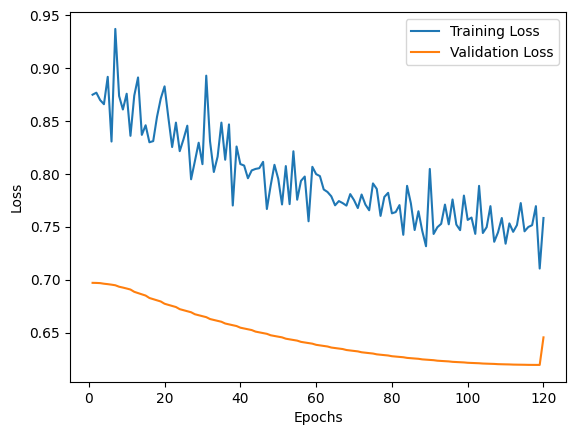

In [ ]:
import ast
with open('losses.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    loss_values = {}
    eval_loss_values = {}

    for row in reader:
        data = ast.literal_eval(row[0])
        if 'loss' in data:
            loss_values[data['step']] = data['loss']
        if 'eval_loss' in data:
            eval_loss_values[data['step']] = data['eval_loss']

    common_steps = sorted(set(loss_values.keys()) & set(eval_loss_values.keys()))

    common_loss_values = [loss_values[step] for step in common_steps]
    common_eval_loss_values = [eval_loss_values[step] for step in common_steps]
    plt.plot(range(1,len(common_steps)+1), common_loss_values, label='Training Loss')
    plt.plot(range(1,len(common_steps)+1), common_eval_loss_values, label='Validation Loss')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    #plt.title('Training and Validation Loss')
    plt.show()